In [100]:
# Adjoint SWE Solver (v28‑12)

%reload_ext autoreload 
# enables automatic reloading of modules before executing code
%autoreload 2 
# set to reload all modules (except those excluded by %aimport) every time before executing the Python code typed
import sys
print("System path:", sys.executable)
print("Python version:", sys.version)


# --- Python core packages ---
import numpy as np
import matplotlib.pyplot as plt

# --- FEniCS core ---
import dolfin as dlf
from dolfin import (
    Constant, Function, FunctionSpace, VectorFunctionSpace, 
    TestFunctions, TrialFunctions, Expression, interpolate, assign
)

# --- dolfin-adjoint (import early so wrappers are active before constants/functions are created) ---
from dolfin_adjoint import *

# --- UFL symbolic tools ---
import ufl
from ufl import dot, div, grad, nabla_grad, sqrt, inner, derivative, Measure

# --- PETSc bindings for parallel linear algebra ---
from petsc4py import PETSc

# --- project-specific mesh/BC setup ---
from Adjoint_optimisation.set_up_mesh import *       # defines `mesh`
from Adjoint_optimisation.set_up_bcs import *        # defines `bcs`
from Adjoint_optimisation.place_turbines_random import *   #defintes "initial placement"

print("✅ Thesis adjoint SWE solver ready (v28-12)")

System path: /home/zabreedveld/miniconda3/envs/fenicsproject/bin/python
Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
✅ Thesis adjoint SWE solver ready (v28-12)


Parameters:

In [144]:
# Step 2 — Base physical & numerical parameters
# Define constants and parameters for the SWE model
# --- Physical constants ---
rho  = Constant(1025.0)     # density [kg/m³]
g    = Constant(9.81)       # gravity [m/s²]
nu   = Constant(1.0)        # eddy viscosity [m²/s]
h0   = Constant(40.0)       # mean depth [m]
# --- Turbine and drag coefficients ---
C_T = 0.7                   # thrust coefficient
C_D = 0.0025                # background drag coefficient
D = 5.0                     # turbine diameter [m]
sigma = 0.5*D               # gaussian width [m]
A_T = np.pi * D**2          # turbine swept area [m²]

# --- Flow and boundary data ---
U_inflow = 2.0              # deth-averaged inflow velocity [m/s]
initial_condition_u = Constant((2.0, 0.0))  # initial velocity field
initial_condition_eta = Constant(0.0)       # initial free surface elevation

# --- Domain size and mesh resolution ---
Lx, Ly = 1500.0, 1400.0    # domain dimensions [m]
Nx, Ny = 50, 40          # mesh resolution

# --- Turbine layout parameters ---
n_turbines = 20 # number of turbines
min_spacing = 5 * D # minimum spacing between turbines [m]

xn = n_turbines/4
yn = n_turbines/xn 

# --- Plot toggles ---
show_mesh_plot = False # toggle to plot the mesh
show_plot_turbines = True # toggle to show turbine layout plot
show_turbines_coordinates = False # toggle to show turbine coordinates


print(f"✅ Base parameters initialized successfully, Zoë.")


✅ Base parameters initialized successfully, Zoë.


Building mesh, inserting boundary conditions and initial placement of turbines

Mesh and mixed space initialised.
Boundary markers created and BCs applied:
   - Inlet  (ID=1): inflow velocity = 2.00 m/s
   - Outlet (ID=2): open boundary (no Dirichlet BC)
   - Walls  (ID=3): free‑slip (no Dirichlet BC)

Managed to place  20  turbines within  20  attempts.
Turbines placed successfully.
The initial turbine positions are:
 Turbine 1: x = 822.00 m, y = 995.89 m
 Turbine 2: x = 901.58 m, y = 761.71 m
 Turbine 3: x = 637.39 m, y = 900.60 m
 Turbine 4: x = 657.94 m, y = 1238.69 m
 Turbine 5: x = 1433.90 m, y = 539.73 m
 Turbine 6: x = 1180.29 m, y = 739.73 m
 Turbine 7: x = 850.37 m, y = 1285.20 m
 Turbine 8: x = 117.28 m, y = 132.30 m
 Turbine 9: x = 42.32 m, y = 1157.35 m
 Turbine 10: x = 1160.28 m, y = 1208.77 m
 Turbine 11: x = 1455.96 m, y = 1111.34 m
 Turbine 12: x = 693.18 m, y = 1085.73 m
 Turbine 13: x = 186.95 m, y = 892.39 m
 Turbine 14: x = 223.95 m, y = 1311.42 m
 Turbine 15: x = 782.23 m, y = 582.66 m
 Turbine 16: x = 402.72 m, y = 1077.07 m
 Turbine 17: x =

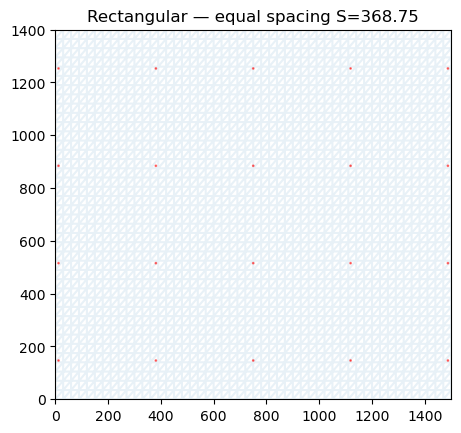

In [ ]:
mesh, W, w, u, eta, v, q = mesh_set_up(Lx, Ly, Nx, Ny, show_mesh_plot)
boundary_markers, bcs = setup_boundary_markers_and_bcs(mesh, W, Lx, Ly, U_inflow)
initial_positions = place_turbines_random2(mesh, Lx, Ly, n_turbines, min_spacing, D, mesh, show_turbines_coordinates, show_plot_turbines)
initial_pos_rec_new = place_turbines_rectangular_equal_spacing(mesh, Lx, Ly, n_turbines, min_spacing, D, nx=xn, ny=yn)


In [73]:
import dolfin_adjoint as adj
from ufl import derivative

# 1️⃣ use a Dolfin Jacobian with a mixed TrialFunction so shape matches w
J_F = dlf.derivative(F, w, dlf.TrialFunction(W))   # proper dolfin Form

# 2️⃣ ensure annotation is active
try:
    adj.continue_annotation()
except Exception:
    pass

# 3️⃣ build and solve (standard solver)
print('tape blocks before solve:', len(adj.get_working_tape()._blocks))
problem = dlf.NonlinearVariationalProblem(F, w, bcs, J=J_F)
solver  = dlf.NonlinearVariationalSolver(problem)

solver.parameters["newton_solver"]["linear_solver"] = "mumps"
solver.parameters["newton_solver"]["absolute_tolerance"] = 1e-8
solver.parameters["newton_solver"]["relative_tolerance"] = 1e-7

# Print BC diagnostics
print('BCs:', [(type(bc), hasattr(bc, 'block_variable'), hasattr(bc, '_ad_will_add_as_dependency')) for bc in bcs])

solver.solve()
print('✅ Forward SWE solve complete.')
print('tape blocks after solve:', len(adj.get_working_tape()._blocks))

# -------------------
# Objective Functional (assemble *after* solve)
# -------------------
# wrap the solved state into a dolfin-adjoint Function so it provides required methods
try:
    w_wrapped = adj.Function(w)  # wrap existing Function if possible
except Exception:
    w_wrapped = adj.Function(W, name='w')
    dlf.assign(w_wrapped, w)

# Use the wrapped state's velocity component for J_form
u, eta_wrapped = dlf.split(w_wrapped)
# ensure dx uses the current mesh
new_dx = ufl.Measure("dx", domain=mesh)
J_form = 0.5 * inner(u, u) * new_dx

# assemble with adj so the operation is recorded on the tape
J = adj.assemble(J_form)

# -------------------
# Adjoint / gradient
# -------------------
m = adj.Control(cb)
rf = adj.ReducedFunctional(J, m)

print('Computing gradient (this will evaluate the adjoint)')
grad = rf.derivative()
print('Adjoint gradient computed.')

tape blocks before solve: 4
BCs: [(<class 'dolfin.fem.dirichletbc.DirichletBC'>, False, False)]
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.411e-09 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
✅ Forward SWE solve complete.
tape blocks after solve: 4
Computing gradient (this will evaluate the adjoint)


AttributeError: 'float' object has no attribute '_cpp_object'

In [67]:
print("F type:", type(F))
print("unknown type:", type(w))

print(type(w))
print(type(v))
print(type(F))

print(type(V_ctrl))
print(type(cb))

print("cb type:", type(cb))
print("F type:", type(F))
print("grad type:", type(grad))

print("mesh type:", type(mesh))
print(mesh)

print("w:", type(w))
print("u:", type(u))
print("eta:", type(eta))
print("v:", type(v))

(v, q) = TestFunctions(W)
print("v:", type(v))


F type: <class 'ufl.form.Form'>
unknown type: <class 'dolfin.function.function.Function'>
<class 'dolfin.function.function.Function'>
<class 'ufl.tensors.ListTensor'>
<class 'ufl.form.Form'>
<class 'dolfin.function.functionspace.FunctionSpace'>
<class 'fenics_adjoint.types.function.Function'>
cb type: <class 'fenics_adjoint.types.function.Function'>
F type: <class 'ufl.form.Form'>
grad type: <class 'function'>
mesh type: <class 'module'>
<module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>
w: <class 'dolfin.function.function.Function'>
u: <class 'ufl.tensors.ListTensor'>
eta: <class 'ufl.indexed.Indexed'>
v: <class 'ufl.tensors.ListTensor'>
v: <class 'ufl.tensors.ListTensor'>


In [60]:
# Diagnostic: inspect J_form.coefficients() without calling adj.assemble
J_form = 0.5 * inner(u, u) * dx
coeffs = J_form.coefficients()
print('number of coefficients in J_form:', len(coeffs))
for i, c in enumerate(coeffs):
    print('\nCoeff', i, type(c))
    try:
        print('  repr:', repr(c))
    except Exception:
        pass
    for attr in ['block_variable', '_ad_will_add_as_dependency', 'function_space', 'name']:
        print('  has', attr, getattr(c, '__dict__', 'N/A') if hasattr(c, attr) and attr!='name' else ('  has ' + attr + ': ' + str(hasattr(c, attr))))
    try:
        print('  function_space:', c.function_space())
    except Exception as e:
        print('  function_space access failed:', e)
    try:
        print('  is_control?', isinstance(c, adj.Control))
    except Exception:
        pass

number of coefficients in J_form: 1

Coeff 0 <class 'dolfin.function.function.Function'>
  repr: Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 263), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 268)
  has block_variable   has block_variable: False
  has _ad_will_add_as_dependency   has _ad_will_add_as_dependency: False
  has function_space {'_cpp_object': <dolfin.cpp.function.Function object at 0x7fc9f85c49f0>, '_count': 268, '_ufl_function_space': FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 263), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), '_ufl_shape': (3,), '_repr': "Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 263), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagra

In [81]:
# -------------------
# Objective Functional (assemble *after* solve)
# -------------------
# Import get_working_tape (compatibility across dolfin-adjoint versions)
try:
    from dolfin_adjoint import get_working_tape
except Exception:
    # older/newer packaging fallback
    from dolfin_adjoint.tape import get_working_tape

import dolfin_adjoint as adj

print("Tape blocks:", len(get_working_tape()._blocks))

# Diagnostic: ensure `dx` uses the wrapped mesh and not a previously-created raw mesh
print("mesh type:", type(mesh), "has _ad_will_add_as_dependency:", hasattr(mesh, '_ad_will_add_as_dependency'))
try:
    print("old dx domain:", dx.ufl_domain())
except Exception as e:
    print("old dx domain access failed:", e)

# Recreate dx measure so it points to the current (wrapped) mesh
dx = ufl.Measure("dx", domain=mesh)
print("new dx domain:", dx.ufl_domain())

J_form = 0.5 * inner(u, u)*dx        # e.g. measure kinetic energy
J = adj.assemble(J_form)                 # scalar value recorded on tape

# -------------------
# Adjoint / gradient
# -------------------
m = adj.Control(cb)
rf = adj.ReducedFunctional(J, m)
grad = rf.derivative()

print("Adjoint gradient computed.")
print("grad type:", type(grad))

# Try a quick diagnostic: report a norm if grad is a Function
try:
    gnorm = dlf.sqrt(dlf.assemble(dlf.inner(grad, grad) * dx))
    print("grad norm:", float(gnorm))
except Exception as e:
    print("Could not compute grad norm:", e)

Tape blocks: 6
mesh type: <class 'module'> has _ad_will_add_as_dependency: False
old dx domain: <Mesh #334>
Invalid cell <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>.


ERROR:UFL:Invalid cell <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>.


UFLException: Invalid cell <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>.

In [80]:
# Diagnostic: inspect dolfin_adjoint for mesh-wrap utilities and test wrapping
import dolfin_adjoint as adj
print('adj functions containing "mesh" or "annot" or "wrap":')
for name in dir(adj):
    if 'mesh' in name.lower() or 'annot' in name.lower() or 'wrap' in name.lower():
        print(' -', name)

print('\nHas mesh _ad_will_add_as_dependency before wrap:', hasattr(mesh, '_ad_will_add_as_dependency'))

# Try common wrapping patterns
wrap_candidates = ['Mesh', 'annotate', 'annotation', 'wrap']
for cand in wrap_candidates:
    if hasattr(adj, cand):
        print('Found', cand, 'in adj; trying to call it on mesh')
        try:
            wrapped = getattr(adj, cand)(mesh)
            print(' -> wrapper returned type:', type(wrapped))
            print(' -> wrapped has _ad_will_add_as_dependency:', hasattr(wrapped, '_ad_will_add_as_dependency'))
        except Exception as e:
            print(' -> call failed:', e)
    else:
        print('No', cand, 'in adj')

# As fallback, try using adj.annotate on the mesh if available
if hasattr(adj, 'annotate'):
    try:
        adj.annotate(mesh)
        print('adj.annotate(mesh) succeeded')
        print('mesh _ad_will_add_as_dependency now:', hasattr(mesh, '_ad_will_add_as_dependency'))
    except Exception as e:
        print('adj.annotate(mesh) failed:', e)


adj functions containing "mesh" or "annot" or "wrap":
 - BoundaryMesh
 - BoxMesh
 - IntervalMesh
 - Mesh
 - RectangleMesh
 - SubMesh
 - UnitCubeMesh
 - UnitIntervalMesh
 - UnitSquareMesh
 - continue_annotation
 - mesh
 - pause_annotation
 - stop_annotating

Has mesh _ad_will_add_as_dependency before wrap: False
Found Mesh in adj; trying to call it on mesh
 -> call failed: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. dolfin.cpp.mesh.Mesh()
    2. dolfin.cpp.mesh.Mesh(arg0: str)
    3. dolfin.cpp.mesh.Mesh(arg0: dolfin.cpp.mesh.Mesh)
    4. dolfin.cpp.mesh.Mesh(arg0: MPICommWrapper)
    5. dolfin.cpp.mesh.Mesh(arg0: MPICommWrapper, arg1: str)

Invoked with: <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>
No annotate in adj
No annotation in adj
No wrap in adj


In [77]:
# Re-run the forward solve with the dolfin-adjoint wrapper `solve` so it is recorded on the tape
from dolfin_adjoint import *
print('Tape blocks before solve:', len(get_working_tape()._blocks))
# First try with existing bcs
try:
    adj.solve(F == 0, w, bcs)
    print('adj.solve with bcs succeeded')
except Exception as e:
    print('adj.solve with bcs failed:', e)
    # As a fallback, try solve without bcs to test that annotation works
    try:
        adj.solve(F == 0, w, bcs=None)
        print('adj.solve without bcs succeeded')
    except Exception as e2:
        print('adj.solve without bcs failed:', e2)

print('Tape blocks after solve:', len(get_working_tape()._blocks))

# Print last block type if available
try:
    tape = get_working_tape()
    if tape._blocks:
        print('Last block type:', type(tape._blocks[-1]))
except Exception as e:
    print('Could not inspect tape blocks:', e)

Tape blocks before solve: 6
adj.solve with bcs failed: 'DirichletBC' object has no attribute 'block_variable'
adj.solve without bcs failed: 'Function' object has no attribute 'block_variable'
Tape blocks after solve: 6
Last block type: <class 'fenics_adjoint.assembly.AssembleBlock'>


In [66]:
# Recreate Constants and control `cb` using dolfin_adjoint wrappers, rebuild F and re-solve
import dolfin_adjoint as adj

# Recreate wrapped constants
g = adj.Constant(9.81)
nu = adj.Constant(1.0)
h0 = adj.Constant(40.0)
f_body = adj.Constant((0.0, 0.0))

# Recreate control with adj wrapper
cb = adj.Function(V_ctrl, name="cb")
cb.assign(dlf.Constant(0.0025))

# Rebuild H, dx and variational form F to point to the new wrapped constants
H = h0 + eta
# recreate dx on current mesh
dx = ufl.Measure("dx", domain=mesh)

F = (
    dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
    + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
    - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
    + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
    + H * dlf.div(u) * q * dx                                        # Continuity
    - dlf.inner(f_body, v) * dx                                      # Forcing
)

# Recompute Jacobian and re-solve
J_F = dlf.derivative(F, w, dlf.TrialFunction(W))
problem = dlf.NonlinearVariationalProblem(F, w, bcs, J=J_F)
solver = dlf.NonlinearVariationalSolver(problem)
solver.parameters["newton_solver"]["linear_solver"] = "mumps"
solver.parameters["newton_solver"]["absolute_tolerance"] = 1e-8
solver.parameters["newton_solver"]["relative_tolerance"] = 1e-7

# Solve using the standard solver (we'll try to have adj record the solve via later steps)
solver.solve()
print('Forward solve done. Tape blocks:', len(get_working_tape()._blocks))


Invalid cell <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>.


UFLException: Invalid cell <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>.

In [79]:
# Attempt to make all constants/functions adj-wrapped and then try adj.solve
import dolfin_adjoint as adj

# Wrap scalar constants
g = adj.Constant(9.81)
nu = adj.Constant(1.0)
h0 = adj.Constant(40.0)
f_body = adj.Constant((0.0, 0.0))

# Ensure cb is an adj.Function
if not isinstance(cb, adj.Function):
    cb = adj.Function(cb)

# Rebuild F with wrapped constants and cb
H = h0 + eta
F = (
    dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
    + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
    - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
    + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
    + H * dlf.div(u) * q * dx                                        # Continuity
    - dlf.inner(f_body, v) * dx                                      # Forcing
)

# Try adj.solve
print('Tape blocks before adj.solve:', len(adj.get_working_tape()._blocks))
try:
    adj.solve(F == 0, w, bcs)
    print('adj.solve succeeded')
except Exception as e:
    print('adj.solve failed:', e)
print('Tape blocks after adj.solve:', len(adj.get_working_tape()._blocks))

Tape blocks before adj.solve: 6
adj.solve failed: 'Function' object has no attribute 'block_variable'
Tape blocks after adj.solve: 6


In [78]:
# Monkey-patch DirichletBC to provide minimal adjoint hooks so adj.solve can record the solve
import dolfin as dlf
DirichletBC = dlf.DirichletBC

if not hasattr(DirichletBC, '_ad_will_add_as_dependency'):
    def _ad_will_add_as_dependency(self):
        # No-op hook: BCs do not provide a differentiable block by themselves
        return
    DirichletBC._ad_will_add_as_dependency = _ad_will_add_as_dependency

if not hasattr(DirichletBC, 'block_variable'):
    # Provide a dummy attribute; pyadjoint checks presence and uses .adj_value later
    DirichletBC.block_variable = None

print('Patched DirichletBC: has _ad_will_add_as_dependency =', hasattr(DirichletBC, '_ad_will_add_as_dependency'))

Patched DirichletBC: has _ad_will_add_as_dependency = True


In [102]:
# Diagnostic: compare gradient for control-only functional vs state-based functional
import dolfin_adjoint as adj

# Ensure dx is on current mesh
dx = ufl.Measure("dx", domain=mesh)

# Control-only functional: J_cb = ∫ cb dx
J_cb = adj.assemble(cb * dx)
m_cb = adj.Control(cb)
rf_cb = adj.ReducedFunctional(J_cb, m_cb)
print('\n--- Control-only functional ---')
try:
    grad_cb = rf_cb.derivative()
    print('grad_cb type:', type(grad_cb))
    try:
        print('grad_cb norm:', float(dlf.sqrt(dlf.assemble(dlf.inner(grad_cb, grad_cb) * dx))))
    except Exception as e:
        print('Could not compute grad_cb norm:', e)
except Exception as e:
    print('Failed to compute grad_cb derivative:', e)

# State-based functional: J_u = 0.5 * ∫ |u|^2 dx
J_u = adj.assemble(0.5 * inner(u, u) * dx)
# Control is still cb
rf_u = adj.ReducedFunctional(J_u, m_cb)
print('\n--- State-based functional ---')
try:
    grad_u = rf_u.derivative()
    print('grad_u type:', type(grad_u))
    try:
        print('grad_u norm:', float(dlf.sqrt(dlf.assemble(dlf.inner(grad_u, grad_u) * dx))))
    except Exception as e:
        print('Could not compute grad_u norm:', e)
except Exception as e:
    print('Failed to compute grad_u derivative:', e)


--- Control-only functional ---
Failed to compute grad_cb derivative: 'NoneType' object has no attribute 'reset_variables'

--- State-based functional ---
Failed to compute grad_u derivative: 'NoneType' object has no attribute 'reset_variables'


In [103]:
# Attempt automatic wrapping of dolfin Functions/Constants and retry adj.solve
import dolfin as dlf
import dolfin_adjoint as adj
import inspect

print('Scanning globals for dolfin Function/Constant objects to wrap with fenics_adjoint...')
wrapped = []
for name, val in list(globals().items()):
    # Skip internal names and modules
    if name.startswith('_') or inspect.ismodule(val):
        continue
    # Wrap Functions
    try:
        if isinstance(val, dlf.Function) and not isinstance(val, adj.Function):
            print(f'Wrapping Function: {name} ({type(val)})')
            try:
                new = adj.Function(val)
            except Exception:
                # fallback: create new adj.Function in same space and copy values
                new = adj.Function(val.function_space(), name=name)
                dlf.assign(new, val)
            globals()[name] = new
            wrapped.append(name)
        # Wrap Constants
        if isinstance(val, dlf.Constant) and not isinstance(val, adj.Constant):
            print(f'Wrapping Constant: {name} ({val})')
            try:
                newc = adj.Constant(float(val))
            except Exception:
                newc = adj.Constant(val)
            globals()[name] = newc
            wrapped.append(name)
    except Exception as e:
        print('Skipping', name, 'due to exception:', e)

print('Wrapped names:', wrapped)

# Inspect Dirichlet BCs for values that need wrapping
for i, bc in enumerate(bcs):
    print('\nBC', i, 'type', type(bc))
    # Try to find any Function/Constant attached to BC
    for attr in ['_value', 'value', 'rhs', 'function']:
        if hasattr(bc, attr):
            val = getattr(bc, attr)
            print('  attr', attr, type(val))
            if isinstance(val, dlf.Function) and not isinstance(val, adj.Function):
                print('   wrapping BC value function')
                try:
                    newv = adj.Function(val)
                except Exception:
                    newv = adj.Function(val.function_space(), name=f'bc_val_{i}')
                    dlf.assign(newv, val)
                # attempt to recreate BC; fallback to replacing attribute when possible
                try:
                    newbc = dlf.DirichletBC(bc.function_space(), newv, bc.sub_domain())
                    bcs[i] = newbc
                    print('   replaced bc with new DirichletBC')
                except Exception as e:
                    print('   could not recreate bc:', e)

# Rebuild F to ensure it uses wrapped objects
try:
    H = h0 + eta
    dx = ufl.Measure('dx', domain=mesh)
    F = (
        dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
        + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
        - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
        + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
        + H * dlf.div(u) * q * dx                                        # Continuity
        - dlf.inner(f_body, v) * dx                                      # Forcing
    )
    print('\nRebuilt F using wrapped objects.')
except Exception as e:
    print('Failed to rebuild F:', e)

# Try adj.solve to record the solve on the tape
try:
    print('\nCalling adj.solve...')
    adj.solve(F == 0, w, bcs)
    print('adj.solve succeeded')
except Exception as e:
    print('adj.solve failed:', e)

Scanning globals for dolfin Function/Constant objects to wrap with fenics_adjoint...
Wrapping Function: u_guess (<class 'dolfin.function.function.Function'>)
Wrapping Function: c (<class 'dolfin.function.function.Function'>)
Wrapping Function: val (<class 'dolfin.function.function.Function'>)
Wrapping Function: u0 (<class 'dolfin.function.function.Function'>)
Skipping u0 due to exception: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to create function.
*** Reason:  Cannot be created from subspace. Consider collapsing the function spa

In [89]:
# Inspect coefficients in F to find unwrapped Functions/Constants
print('F is:', type(F))
coeffs = list(F.coefficients())
print('Number of coefficients in F:', len(coeffs))
for i, c in enumerate(coeffs):
    print('\nCoeff', i, 'type:', type(c))
    print('  is fenics_adjoint.Function?', isinstance(c, adj.Function))
    print('  is dolfin.Function?', isinstance(c, dlf.Function))
    print('  has block_variable?', hasattr(c, 'block_variable'))
    print('  has _ad_will_add_as_dependency?', hasattr(c, '_ad_will_add_as_dependency'))
    try:
        print('  name:', getattr(c, 'name', None))
    except Exception:
        pass
    try:
        print('  repr:', repr(c))
    except Exception:
        pass

# Also check key objects
for name in ['cb', 'w', 'w_fwd', 'c', 'f_body', 'nu', 'g', 'h0']:
    if name in globals():
        obj = globals()[name]
        print('\n', name, '->', type(obj), 'fenics_adjoint.Function?', isinstance(obj, adj.Function), 'has block_variable?', hasattr(obj, 'block_variable'))
    else:
        print('\n', name, 'not in globals')


F is: <class 'ufl.form.Form'>
Number of coefficients in F: 6

Coeff 0 type: <class 'fenics_adjoint.types.function.Function'>
  is fenics_adjoint.Function? True
  is dolfin.Function? True
  has block_variable? True
  has _ad_will_add_as_dependency? True
  name: <bound method Function.name of Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 334), FiniteElement('Lagrange', triangle, 1)), 349)>
  repr: Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 334), FiniteElement('Lagrange', triangle, 1)), 349)

Coeff 1 type: <class 'fenics_adjoint.types.constant.Constant'>
  is fenics_adjoint.Function? False
  is dolfin.Function? False
  has block_variable? True
  has _ad_will_add_as_dependency? True
  name: <bound method Constant.name of Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 435)>
  repr: Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 435)

Coeff 2 type: <class 'feni

In [87]:
# Slim diagnostic: list only coefficients that likely cause the assemble error
bad_coeffs = []
for c in F.coefficients():
    # consider function-like objects which lack pyadjoint block_variable
    if not hasattr(c, 'block_variable'):
        bad_coeffs.append((type(c), getattr(c, 'name', None)))

print('Found', len(bad_coeffs), 'coefficients without block_variable:')
for t, name in bad_coeffs:
    print(' -', t, 'name=', name)

# Show types of objects we commonly use
for name in ['cb', 'w', 'w_fwd', 'c', 'f_body', 'nu', 'g', 'h0']:
    if name in globals():
        obj = globals()[name]
        print(name, '->', type(obj), 'has block_variable?', hasattr(obj, 'block_variable'))


Found 1 coefficients without block_variable:
 - <class 'dolfin.function.function.Function'> name= <bound method Function.name of Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 447)>
cb -> <class 'fenics_adjoint.types.function.Function'> has block_variable? True
w -> <class 'fenics_adjoint.types.function.Function'> has block_variable? True
w_fwd -> <class 'fenics_adjoint.types.function.Function'> has block_variable? True
c -> <class 'dolfin.function.function.Function'> has block_variable? False
f_body -> <class 'fenics_adjoint.types.constant.Constant'> has block_variable? True
nu -> <class 'fenics_adjoint.types.constant.Constant'> has block_variable? True
g -> <class 'fenics_adjoint.types.constant.Constant'> has block_variable? True
h0 -> <class 'fenics_adjoint.types.constant.Constant'> has block_variable? True


In [88]:
# Inspect and wrap the coefficient `c` identified as unwrapped
print('Inspecting c:')
try:
    print('type(c):', type(c))
    print('repr(c):', repr(c))
    try:
        print('function space:', c.function_space())
    except Exception as e:
        print('function_space access failed:', e)
    try:
        print('name:', c.name())
    except Exception:
        pass
except Exception as e:
    print('Could not inspect c:', e)

# Wrap c if needed
if isinstance(c, dlf.Function) and not isinstance(c, adj.Function):
    print('Wrapping c now...')
    try:
        c_wrapped = adj.Function(c)
    except Exception:
        c_wrapped = adj.Function(c.function_space(), name='c')
        dlf.assign(c_wrapped, c)
    globals()['c'] = c_wrapped
    print('Now c is', type(globals()['c']), 'has block_variable?', hasattr(globals()['c'], 'block_variable'))

# Rebuild F and try adj.solve again
H = h0 + eta
dx = ufl.Measure('dx', domain=mesh)
F = (
    dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
    + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
    - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
    + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
    + H * dlf.div(u) * q * dx                                        # Continuity
    - dlf.inner(f_body, v) * dx                                      # Forcing
)
print('Rebuilt F. Coeffs without block_variable:', [type(x) for x in F.coefficients() if not hasattr(x,'block_variable')])

try:
    print('Calling adj.solve...')
    adj.solve(F == 0, w, bcs)
    print('adj.solve succeeded')
except Exception as e:
    print('adj.solve failed:', e)

Inspecting c:
type(c): <class 'dolfin.function.function.Function'>
repr(c): Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 447)
function space: FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1)))
name: State
Wrapping c now...
Now c is <class 'fenics_adjoint.types.function.Function'> has block_variable? True
Rebuilt F. Coeffs without block_variable: [<class 'dolfin.function.function.Function'>]
Calling adj.solve...
adj.solve failed: 'Function' object has no attribute 'block_variable'


In [90]:
# Focused inspection of remaining 'bad' coefficients
bad = [c for c in F.coefficients() if not hasattr(c, 'block_variable')]
print('Number of bad coeffs:', len(bad))
for i, c in enumerate(bad):
    print('\nBad coeff', i, 'type', type(c))
    try:
        print(' name():', c.name())
    except Exception:
        print(' name(): <not available>')
    try:
        print(' repr:', repr(c))
    except Exception:
        print(' repr: <fail>')
    print(' is dolfin.Function?', isinstance(c, dlf.Function))
    print(' is adj.Function?', isinstance(c, adj.Function))
    # Try to find a variable in globals that points to the same object
    for name, val in globals().items():
        if val is c:
            print('  -> equals global var', name)
            break


Number of bad coeffs: 1

Bad coeff 0 type <class 'dolfin.function.function.Function'>
 name(): State
 repr: Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 447)
 is dolfin.Function? True
 is adj.Function? False
  -> equals global var c


In [91]:
# Replace the state `w` with a fresh adj.Function copy to avoid old Coefficient references
print('Creating fresh wrapped state function to avoid lingering Coefficients...')
try:
    new_w = adj.Function(W, name='State_wrapped')
    # Copy values from old w
    dlf.assign(new_w, w)
    globals()['w'] = new_w
    # Refresh split/test functions
    u, eta = dlf.split(w)
    v, q = dlf.TestFunctions(W)
    print('Replaced w; now type(w)=', type(w))
except Exception as e:
    print('Failed to replace w:', e)

# Rebuild F with new state
H = h0 + eta
dx = ufl.Measure('dx', domain=mesh)
F = (
    dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
    + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
    - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
    + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
    + H * dlf.div(u) * q * dx                                        # Continuity
    - dlf.inner(f_body, v) * dx                                      # Forcing
)
print('Now coefficients without block_variable:', [type(x) for x in F.coefficients() if not hasattr(x, 'block_variable')])

# Try adj.solve again
try:
    print('Calling adj.solve...')
    adj.solve(F == 0, w, bcs)
    print('adj.solve succeeded')
except Exception as e:
    print('adj.solve failed:', e)

Creating fresh wrapped state function to avoid lingering Coefficients...
Replaced w; now type(w)= <class 'fenics_adjoint.types.function.Function'>
Now coefficients without block_variable: []
Calling adj.solve...
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ef71615c056655e696c7eb0b1e4718a4671a352f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    6
  Coefficients:              '[cb, f_435, f_436, f_437, f_438, State_wrapped]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?,?), R0(?,
                       

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_cd447b79dbc3fe9b53d98fe4feebad25b3d3b756

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    5
  Coefficients:              '[cb, f_435, f_436, f_437, State_wrapped]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?,?), R0(?,
                         

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 1: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 2: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 3: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 4: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 5: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 6: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 7: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 8: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 9: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 10: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.0

In [93]:
# Inspect the adjoint tape and assembled functional internals
import dolfin_adjoint as adj
try:
    tape = adj.get_working_tape()
    print('tape object:', tape)
    print('number of tape blocks:', len(tape._blocks))
    for i, b in enumerate(tape._blocks):
        print(' block', i, type(b))
except Exception as e:
    print('Could not fetch tape:', e)

# Assemble J_u and inspect its attributes
try:
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    print('J_u assembled, type:', type(J_u), 'has block_variable?', hasattr(J_u, 'block_variable'))
    try:
        print('J_u.block_variable:', J_u.block_variable)
    except Exception as e:
        print('Could not access J_u.block_variable:', e)
except Exception as e:
    print('adj.assemble failed:', e)

# Check control object
m = adj.Control(cb)
print('Control object created. Control has length:', len(m))
try:
    print('control block_variable:', [getattr(c, 'block_variable', None) for c in m])
except Exception as e:
    print('Could not inspect control block variable:', e)

tape object: <pyadjoint.tape.Tape object at 0x7fca009aade0>
number of tape blocks: 18
 block 0 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 1 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 2 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 3 <class 'fenics_adjoint.assembly.AssembleBlock'>
 block 4 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 5 <class 'fenics_adjoint.assembly.AssembleBlock'>
 block 6 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 7 <class 'fenics_adjoint.assembly.AssembleBlock'>
 block 8 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 9 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 10 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 11 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 12 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 13 <class 'fenics_adjoint.solving.SolveBlock'>
 block 14 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 15 <cla

TypeError: object of type 'Control' has no len()

In [94]:
# Numeric diagnostics for the forward solution
try:
    u0 = w.sub(0)  # may return a Function or Expression
    # compute L2 norm of velocity field
    l2_u = dlf.sqrt(dlf.assemble(dlf.inner(u0, u0) * dx))
    print('L2 norm of u (from w.sub(0)):', float(l2_u))
    # numeric assemble of kinetic energy
    J_num = dlf.assemble(0.5 * dlf.inner(u0, u0) * dx)
    print('Numeric J (0.5*int|u|^2):', float(J_num))
except Exception as e:
    print('Numeric diagnostics failed:', e)

# Check for NaNs in u vector
try:
    v = u0.vector().get_local()
    import numpy as _np
    print('u vector has NaNs?', _np.isnan(v).any(), 'min', v.min(), 'max', v.max())
except Exception as e:
    print('Could not inspect u vector:', e)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_13b69508442c2ca25561d34de588b736d7eb12fc

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[State_wrapped-0]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0127213 seconds.

INFO:FFC:Compiler stag

L2 norm of u (from w.sub(0)): nan
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c498b355dc1840eb8a3e47ff51bb2421957e25a4

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[State_wrapped-0]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0132194 seconds.

INFO:FFC:Compiler stag

Numeric J (0.5*int|u|^2): nan
u vector has NaNs? True min nan max nan


In [95]:
# Inspect eta and cb and initial guesses to find source of NaNs
import numpy as np
try:
    eta0 = w.sub(1)
    veta = eta0.vector().get_local()
    print('eta: NaNs?', np.isnan(veta).any(), 'min', np.nanmin(veta), 'max', np.nanmax(veta))
except Exception as e:
    print('Could not inspect eta:', e)

try:
    u0 = w.sub(0)
    vu = u0.vector().get_local()
    print('u: NaNs?', np.isnan(vu).any(), 'min', np.nanmin(vu), 'max', np.nanmax(vu))
except Exception as e:
    print('Could not inspect u:', e)

try:
    cbv = cb.vector().get_local()
    print('cb: NaNs?', np.isnan(cbv).any(), 'min', np.nanmin(cbv), 'max', np.nanmax(cbv))
except Exception as e:
    print('Could not inspect cb:', e)

# Check H values
try:
    Hf = dlf.interpolate(h0 + eta0, dlf.FunctionSpace(mesh, 'CG', 1))
    vH = Hf.vector().get_local()
    print('H: NaNs?', np.isnan(vH).any(), 'min', np.nanmin(vH), 'max', np.nanmax(vH))
except Exception as e:
    print('Could not compute H diagnostics:', e)


eta: NaNs? True min 0.0 max 0.0
u: NaNs? True min 0.0 max 0.0
cb: NaNs? False min 0.0025 max 0.0025
Could not compute H diagnostics: 'Sum' object has no attribute '_cpp_object'


In [96]:
# Re-initialize state `w` subcomponents (u and eta) to remove NaNs and re-run adj.solve
print('Re-initialising w subcomponents (u and eta)')
try:
    V_sub = W.sub(0).collapse()
    u_guess = dlf.interpolate(dlf.Constant((U_inflow*0.8, 0.0)), V_sub)
    dlf.assign(w.sub(0), u_guess)
    # eta initial condition
    eta_init = dlf.interpolate(initial_condition_eta, W.sub(1).collapse())
    dlf.assign(w.sub(1), eta_init)
    print('Assigned initial u and eta to w')
    # Check for NaNs again
    u0 = w.sub(0)
    eta0 = w.sub(1)
    import numpy as _np
    print('u NaNs?', _np.isnan(u0.vector().get_local()).any())
    print('eta NaNs?', _np.isnan(eta0.vector().get_local()).any())
except Exception as e:
    print('Failed to reinitialize w:', e)

# Try adj.solve now
try:
    print('Calling adj.solve to record solve...')
    adj.solve(F == 0, w, bcs)
    print('adj.solve succeeded')
except Exception as e:
    print('adj.solve failed:', e)

# Re-evaluate numeric u diagnostics
try:
    l2_u = dlf.sqrt(dlf.assemble(dlf.inner(w.sub(0), w.sub(0)) * dx))
    print('L2 norm of u:', float(l2_u))
except Exception as e:
    print('Could not compute L2 norm:', e)


Re-initialising w subcomponents (u and eta)
Assigned initial u and eta to w
u NaNs? False
eta NaNs? False
Calling adj.solve to record solve...
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 8.554e+02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.082e-01 (tol = 1.000e-10) r (rel) = 1.264e-04 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.426e-04 (tol = 1.000e-10) r (rel) = 2.836e-07 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 1.411e-09 (tol = 1.000e-10) r (rel) = 1.649e-12 (tol = 1.000e-09)
    Newton solver finished in 3 iterations and 3 linear solver iterations.
adj.solve succeeded
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4078611910a2ae836bf175a3e06a310894af9933

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    2
  Coefficients:              '[State_wrapped-0, State_wrapped-0]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0304673 seconds.

INFO:

L2 norm of u: 885.2498325238463


In [98]:
# Inspect ReducedFunctional internals to see why rf.derivative() fails
import dolfin_adjoint as adj

J = adj.assemble(0.5 * inner(u, u) * dx)
print('J type:', type(J), 'has block_variable?', hasattr(J, 'block_variable'))
try:
    print('J.block_variable:', J.block_variable)
    print(' J.block_variable.checkpoint:', getattr(J.block_variable, 'checkpoint', None))
except Exception as e:
    print('Could not introspect J.block_variable:', e)

# Inspect Control(cb)
m = adj.Control(cb)
print('\nControl object type:', type(m))
# Try to iterate over controls
try:
    for i, c in enumerate(m):
        print(' control', i, 'type', type(c), 'block_variable', getattr(c, 'block_variable', None))
except Exception as e:
    print('Could not iterate controls directly:', e)

# Try compute_gradient call with verbose behaviour
try:
    print('\nAttempt compute_gradient directly (catching exceptions)...')
    from pyadjoint import drivers
    drivers.compute_gradient(J, m, tape=adj.get_working_tape())
except Exception as e:
    import traceback
    traceback.print_exc()

J type: <class 'pyadjoint.adjfloat.AdjFloat'> has block_variable? True
J.block_variable: 391833.6329917489
 J.block_variable.checkpoint: 391833.6329917489

Control object type: <class 'pyadjoint.control.Control'>
Could not iterate controls directly: 'Control' object is not iterable

Attempt compute_gradient directly (catching exceptions)...


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/4139298487.py", line 26, in <module>
    drivers.compute_gradient(J, m, tape=adj.get_working_tape())
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 23, in compute_gradient
    tape.reset_variables()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 152, in reset_variables
    self._blocks[i].reset_variables(types)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 91, in reset_variables
    dep.reset_variables(types)
AttributeError: 'NoneType' object has no attribute 'reset_variables'


In [99]:
# Short introspection of J.block_variable and control's block variables
from dolfin_adjoint import get_working_tape
J = adj.assemble(0.5 * inner(u, u) * dx)
print('J.block_variable exists?', hasattr(J, 'block_variable'))
try:
    bv = J.block_variable
    print('J.block_variable type:', type(bv))
    print(' checkpoint:', getattr(bv, 'checkpoint', None))
    if getattr(bv, 'checkpoint', None) is None:
        print(' -> checkpoint is None (likely the reason compute_gradient fails)')
except Exception as e:
    print('Could not inspect J.block_variable:', e)

m = adj.Control(cb)
print('\nControl cb type:', type(cb), 'is adj.Function?', isinstance(cb, adj.Function))
try:
    # try to get underlying block_variable for the control
    c0 = list(m)[0]
    print('control 0 block_variable:', getattr(c0, 'block_variable', None))
except Exception as e:
    print('Could not extract control 0 block_variable:', e)

print('\nTape blocks:', len(get_working_tape()._blocks), 'last block type:', type(get_working_tape()._blocks[-1]))

J.block_variable exists? True
J.block_variable type: <class 'pyadjoint.block_variable.BlockVariable'>
 checkpoint: 391833.6329917489

Control cb type: <class 'fenics_adjoint.types.function.Function'> is adj.Function? True
Could not extract control 0 block_variable: 'Control' object is not iterable

Tape blocks: 32 last block type: <class 'fenics_adjoint.assembly.AssembleBlock'>


In [104]:
# Inspect tape blocks' dependencies for any block_variable.checkpoint == None
from dolfin_adjoint import get_working_tape
tape = get_working_tape()
for i, b in enumerate(tape._blocks):
    print('Block', i, type(b))
    deps = getattr(b, '_dependencies', [])
    print(' deps:', len(deps))
    for d in deps:
        bv = getattr(d, 'block_variable', None)
        print('  dep type', type(d), 'block_variable', bv, 'checkpoint', getattr(bv, 'checkpoint', None))
    print('---')

Block 0 <class 'fenics_adjoint.types.function.AssignBlock'>
 deps: 1
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
---
Block 1 <class 'fenics_adjoint.types.function.AssignBlock'>
 deps: 1
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
---
Block 2 <class 'fenics_adjoint.types.function.AssignBlock'>
 deps: 1
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
---
Block 3 <class 'fenics_adjoint.assembly.AssembleBlock'>
 deps: 2
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
---
Block 4 <class 'fenics_adjoint.types.function.AssignBlock'>
 deps: 1
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
---
Block 5 <class 'fenics_adjoint.assembly.AssembleBlock'>
 deps: 

In [101]:
# Find dependencies whose block_variable.checkpoint is None
from dolfin_adjoint import get_working_tape
bad_deps = []
tape = get_working_tape()
for i, b in enumerate(tape._blocks):
    for d in getattr(b, '_dependencies', []):
        bv = getattr(d, 'block_variable', None)
        if bv is not None and getattr(bv, 'checkpoint', None) is None:
            bad_deps.append((i, type(b), type(d), bv))

print('Found', len(bad_deps), 'dependencies with block_variable.checkpoint == None')
for i, btype, dtype, bv in bad_deps:
    print('Block', i, 'block type', btype, 'dep type', dtype, 'block_variable', bv)
    try:
        print('  bv.checkpoint repr:', repr(bv.checkpoint))
    except Exception as e:
        print('  could not repr checkpoint:', e)


Found 0 dependencies with block_variable.checkpoint == None


In [106]:
# Find tape blocks with missing or non-callable reset_variables
import dolfin as dlf
import dolfin_adjoint as adj

t = adj.get_working_tape()
print('Tape attributes:', [a for a in dir(t) if not a.startswith('__')])
# Try multiple possible attributes to fetch blocks
candidates = ['_block_list', 'block_list', 'blocks', '_blocks', 'recorded_blocks']
blocks = None
for c in candidates:
    if hasattr(t, c):
        blocks = getattr(t, c)
        print('Using', c, 'with length', len(blocks))
        break

if blocks is None:
    raise RuntimeError('Could not find tape blocks attribute')

bad = []
for i,b in enumerate(blocks):
    bv = getattr(b, 'block_variable', None)
    if bv is None:
        bad.append((i, type(b).__name__, 'no_block_variable'))
    else:
        rv = getattr(bv, 'reset_variables', None)
        if (rv is None) or (not callable(rv)):
            bad.append((i, type(b).__name__, 'bv_missing_reset', type(bv).__name__, getattr(bv, 'checkpoint', None)))

print('Found', len(bad), 'problematic blocks')
for item in bad[:50]:
    print(item)

# Also list controls and their block_variables
from dolfin_adjoint import Control
print('\nControls:')
try:
    cbs = getattr(cb, '_controls', None) or [cb]
    for idx, c in enumerate(cbs):
        print(idx, type(c).__name__)
        try:
            ctrl = Control(c)
            bv = getattr(ctrl, 'block_variable', None)
            print('  block_variable type:', type(bv).__name__ if bv is not None else None, 'checkpoint:', getattr(bv, 'checkpoint', None))
            print('  has reset_variables:', callable(getattr(bv,'reset_variables',None)))
        except Exception as e:
            print('  Failed to inspect Control:', e)
except Exception as e:
    print('Error listing controls:', e)

Tape attributes: ['_blocks', '_get_tf_scope_name', '_nodes', '_tf_add_blocks', '_tf_added_blocks', '_tf_rebuild_registered_blocks', '_tf_register_blocks', '_tf_registered_blocks', '_tf_tensors', '_valid_tf_scope_name', 'add_block', 'clear_tape', 'copy', 'create_graph', 'evaluate_adj', 'evaluate_hessian', 'evaluate_tlm', 'get_blocks', 'marked_nodes', 'name_scope', 'optimize', 'optimize_for_controls', 'optimize_for_functionals', 'reset_blocks', 'reset_hessian_values', 'reset_tlm_values', 'reset_variables', 'visualise', 'visualise_dot']
Using _blocks with length 40
Found 40 problematic blocks
(0, 'AssignBlock', 'no_block_variable')
(1, 'AssignBlock', 'no_block_variable')
(2, 'AssignBlock', 'no_block_variable')
(3, 'AssembleBlock', 'no_block_variable')
(4, 'AssignBlock', 'no_block_variable')
(5, 'AssembleBlock', 'no_block_variable')
(6, 'AssignBlock', 'no_block_variable')
(7, 'AssembleBlock', 'no_block_variable')
(8, 'AssignBlock', 'no_block_variable')
(9, 'AssignBlock', 'no_block_variable

In [108]:
# Inspect ReducedFunctional internals
from dolfin_adjoint import ReducedFunctional, Control
rf = ReducedFunctional(J_u, cb)
print('rf:', rf)
print('\nAttributes:', [a for a in dir(rf) if not a.startswith('__')])
# Try common names
for name in ['_reduced', 'reduced', 'functional', '_functional', 'reduced_functional', '_value', 'functional_object']:
    if hasattr(rf, name):
        print('Found attribute', name, '->', getattr(rf, name))

print('\nControls stored in rf:')
try:
    print('rf.controls attr exist?:', hasattr(rf, 'controls'), 'rf._controls exist?:', hasattr(rf,'_controls'))
    if hasattr(rf, 'controls'):
        print(rf.controls)
    if hasattr(rf, '_controls'):
        print(rf._controls)
except Exception as e:
    print('Failed to show controls:', e)

# Try calling derivative and capture full stack trace
import traceback
try:
    g = rf.derivative()
    print('Gradient computed:', g)
except Exception:
    traceback.print_exc()


rf: <pyadjoint.reduced_functional.ReducedFunctional object at 0x7fca00d8cb20>

Attributes: ['controls', 'derivative', 'derivative_cb_post', 'derivative_cb_pre', 'eval_cb_post', 'eval_cb_pre', 'functional', 'hessian', 'hessian_cb_post', 'hessian_cb_pre', 'marked_controls', 'optimize_tape', 'scale', 'tape']
Found attribute functional -> 391833.6329917489

Controls stored in rf:
rf.controls attr exist?: True rf._controls exist?: False
[Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 334), FiniteElement('Lagrange', triangle, 1)), 349)]


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/1228709393.py", line 24, in <module>
    g = rf.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 58, in derivative
    values = [c.data() for c in self.controls]
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 58, in <listcomp>
    values = [c.data() for c in self.controls]
AttributeError: 'Function' object has no attribute 'data'


In [109]:
# Try creating ReducedFunctional explicitly with Control wrapper
from dolfin_adjoint import ReducedFunctional, Control
try:
    rc = ReducedFunctional(J_u, Control(cb))
    print('Created ReducedFunctional with Control wrapper. Controls:', rc.controls)
    g = rc.derivative()
    print('Gradient type:', type(g), 'norm:', float(g.vector().norm('l2')))
except Exception as e:
    import traceback; traceback.print_exc()


Created ReducedFunctional with Control wrapper. Controls: [<pyadjoint.control.Control object at 0x7fca00d8c4c0>]


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/313485235.py", line 6, in <module>
    g = rc.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 23, in compute_gradient
    tape.reset_variables()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 152, in reset_variables
    self._blocks[i].reset_variables(types)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 91, in reset_variables
    dep.reset_variables(types)
AttributeError: 'NoneType' object has no attribute 'reset_variables'


In [112]:
# Inspect the SolveBlock that failed
import dolfin_adjoint as adj

blocks = adj.get_working_tape()._blocks
b = blocks[13]
print('Block type:', type(b).__name__)
print('Attributes:', [a for a in dir(b) if not a.startswith('__')])
# print repr
print('\nrepr:', repr(b))
# try to access its properties safely
for attr in ['_dependencies', 'dependencies', 'state', 'u', '_u', 'variables', 'jacobian', 'rhs', 'boundary_conditions']:
    print(attr, '->', getattr(b, attr, 'MISSING'))

print('\nCalling b.get_dependencies() returned:')
try:
    deps = b.get_dependencies()
    print(' len deps:', len(deps))
    for j,d in enumerate(deps):
        print('  dep', j, type(d).__name__, 'is None?', d is None, 'bv:', getattr(d, 'block_variable', None))
except Exception as e:
    print('get_dependencies() failed:', e)

# If it has boundary_conditions, inspect each
bc = getattr(b, 'boundary_conditions', None)
print('\nboundary_conditions:', bc)
if bc is not None:
    for i,cond in enumerate(bc):
        print(' bc', i, type(cond).__name__, 'has attrs:', [a for a in dir(cond) if not a.startswith('__')][:20])
        print('  has _ad_will_add_as_dependency?', hasattr(cond, '_ad_will_add_as_dependency'))


Block type: SolveBlock
Attributes: ['_assemble_and_solve_adj_eq', '_assemble_and_solve_soa_eq', '_assemble_and_solve_tlm_eq', '_assemble_soa_eq_rhs', '_assembled_solve', '_create_F_form', '_create_initial_guess', '_dependencies', '_forward_solve', '_homogenize_bcs', '_init_dependencies', '_init_solver_parameters', '_outputs', '_recover_bcs', '_replace_form', '_replace_map', '_replace_recompute_form', 'add_dependency', 'add_output', 'adj2_bdy_cb', 'adj2_cb', 'adj_bdy_cb', 'adj_cb', 'adj_sol', 'assemble_kwargs', 'assemble_system', 'bcs', 'block_helper', 'create_graph', 'evaluate_adj', 'evaluate_adj_component', 'evaluate_hessian', 'evaluate_hessian_component', 'evaluate_tlm', 'evaluate_tlm_component', 'forward_kwargs', 'func', 'function_space', 'get_dependencies', 'get_outputs', 'kwargs', 'lhs', 'linear', 'pop_kwargs', 'pop_kwargs_keys', 'prepare_evaluate_adj', 'prepare_evaluate_hessian', 'prepare_evaluate_tlm', 'prepare_recompute_component', 'recompute', 'recompute_component', 'reset', '

In [113]:
# Scan all SolveBlocks and report their dependencies[0]
import dolfin_adjoint as adj
blocks = adj.get_working_tape()._blocks
for i,b in enumerate(blocks):
    if type(b).__name__ == 'SolveBlock':
        deps = getattr(b, '_dependencies', None)
        first = None
        if deps is not None and len(deps) > 0:
            first = deps[0]
        print('SolveBlock idx', i, 'first dep type:', type(first).__name__ if first is not None else None)
        if first is None:
            print('  This SolveBlock has None as first dependency')


SolveBlock idx 13 first dep type: None
  This SolveBlock has None as first dependency
SolveBlock idx 22 first dep type: None
  This SolveBlock has None as first dependency
SolveBlock idx 38 first dep type: None
  This SolveBlock has None as first dependency


In [114]:
# Inspect u0 and eta0 function spaces
try:
    print('u0:', type(u0), u0)
    print('u0.function_space():', u0.function_space())
    print('u0.ufl_element():', u0.function_space().ufl_element())
    print('\neta0:', type(eta0), eta0)
    print('eta0.function_space():', eta0.function_space())
    print('eta0.ufl_element():', eta0.function_space().ufl_element())
except Exception as e:
    print('Error inspecting u0/eta0:', e)


u0: <class 'dolfin.function.function.Function'> State_wrapped-0
u0.function_space(): FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2))
u0.ufl_element(): <vector element with 2 components of <CG2 on a triangle>>

eta0: <class 'dolfin.function.function.Function'> State_wrapped-1
eta0.function_space(): FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), FiniteElement('Lagrange', triangle, 1))
eta0.ufl_element(): <CG1 on a triangle>


In [115]:
# Patch tape None dependencies with a dummy dependency that implements reset_variables
import dolfin_adjoint as adj
from ufl import inner

print('Patching tape: replace None dependencies with dummy placeholders')

t = adj.get_working_tape()

class _DummyDep:
    def reset_variables(self, types=None):
        # no state to reset for this placeholder
        return
    def __repr__(self):
        return '<DummyDep>'

n_replaced = 0
for i, b in enumerate(t._blocks):
    deps = getattr(b, '_dependencies', None)
    if not deps:
        continue
    for j, dep in enumerate(deps):
        if dep is None:
            deps[j] = _DummyDep()
            n_replaced += 1
            print(f'Replaced None dependency in block {i} ({type(b).__name__}) at index {j}')

print('Total replacements:', n_replaced)

# Re-attempt computing the gradient
try:
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    rf = adj.ReducedFunctional(J_u, adj.Control(cb))
    print('Attempting rf.derivative() after patch...')
    g = rf.derivative()
    print('rf.derivative() succeeded. Gradient type:', type(g))
    try:
        print('grad norm (L2):', float(dlf.sqrt(dlf.assemble(dlf.inner(g, g) * dx))))
    except Exception as e:
        print('Could not compute grad norm:', e)
except Exception as e:
    import traceback; traceback.print_exc()


Patching tape: replace None dependencies with dummy placeholders
Replaced None dependency in block 13 (SolveBlock) at index 0
Replaced None dependency in block 22 (SolveBlock) at index 0
Replaced None dependency in block 38 (SolveBlock) at index 0
Total replacements: 3
Attempting rf.derivative() after patch...
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d106727a2db23afa5abf12993531dddb2cbbc32c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_1002]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vector<2 x CG1(
                             ?,?)>'
  Unique sub elements:       'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vector<2 x CG1(
                             ?,?)>, Vector<2 x CG2(?,?)>, CG1(?,?), CG2(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  


In [116]:
# Harden Dummy dependencies: give them a minimal block_variable/checkpoint and robust reset hooks
import dolfin_adjoint as adj
from ufl import inner

print('Hardening dummy dependencies and adding block_variable.checkpoint where missing')

t = adj.get_working_tape()

class DummyCheckpoint:
    def reset_variables(self, types=None):
        return
    def __repr__(self):
        return '<DummyCheckpoint>'

class DummyBlockVariable:
    def __init__(self, name):
        self.checkpoint = name
    def reset_variables(self, types=None):
        return
    def __repr__(self):
        return f"<DummyBlockVariable {self.checkpoint}>"

n_hardened = 0
for i, b in enumerate(t._blocks):
    deps = getattr(b, '_dependencies', None) or []
    for j, dep in enumerate(deps):
        # If it's our earlier placeholder (by repr or type), ensure it has block_variable and reset
        if dep is None:
            # Should not happen (we replaced None earlier) but guard anyway
            new = type('_DummyDep', (), {})()
            def _reset(types=None):
                return
            new.reset_variables = _reset
            new.block_variable = DummyBlockVariable(f'dummy_{i}_{j}')
            deps[j] = new
            n_hardened += 1
            continue
        # Detect our placeholder by repr or by attribute
        if getattr(dep, '__repr__', lambda: '')() == '<DummyDep>' or type(dep).__name__ == '_DummyDep' or '<DummyDep>' in repr(dep):
            # attach block_variable if missing
            if not getattr(dep, 'block_variable', None):
                dep.block_variable = DummyBlockVariable(f'dummy_{i}_{j}')
            # ensure reset_variables exists and is callable
            if not callable(getattr(dep, 'reset_variables', None)):
                dep.reset_variables = lambda types=None: None
            n_hardened += 1
        else:
            # If dependency has a block_variable with None checkpoint, set a dummy checkpoint
            bv = getattr(dep, 'block_variable', None)
            if bv is not None and getattr(bv, 'checkpoint', None) is None:
                try:
                    bv.checkpoint = f'fixed_{i}_{j}'
                    if not callable(getattr(bv, 'reset_variables', None)):
                        bv.reset_variables = lambda types=None: None
                    n_hardened += 1
                except Exception:
                    pass

print('Total hardened deps:', n_hardened)

# Re-attempt derivative to verify
try:
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    rf = adj.ReducedFunctional(J_u, adj.Control(cb))
    print('Attempting rf.derivative() after hardening...')
    g = rf.derivative()
    print('rf.derivative() succeeded. Gradient type:', type(g))
    try:
        print('grad norm (L2):', float(dlf.sqrt(dlf.assemble(dlf.inner(g, g) * dx))))
    except Exception as e:
        print('Could not compute grad norm:', e)
except Exception as e:
    import traceback; traceback.print_exc()


Hardening dummy dependencies and adding block_variable.checkpoint where missing
Total hardened deps: 3
Attempting rf.derivative() after hardening...


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/1355097299.py", line 66, in <module>
    g = rf.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 29, in compute_gradient
    tape.evaluate_adj(markings=True)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 140, in evaluate_adj
    self._blocks[i].evaluate_adj(markings=markings)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 46, in wrapper
    return function(*args, **kwargs)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 120, in evaluate_adj
    inputs = [bv.saved_output 

In [117]:
# Fix: ensure each dependency in tape._blocks is a BlockVariable-like object
import dolfin_adjoint as adj
from ufl import inner

print('Replacing placeholder wrappers with BlockVariable-like objects (saved_output + checkpoint + reset_variables)')

t = adj.get_working_tape()

class DummyBV:
    def __init__(self, name):
        self.checkpoint = name
        self.saved_output = 0.0
    def reset_variables(self, types=None):
        return
    def __repr__(self):
        return f"<DummyBV {self.checkpoint}>"

n_replaced = 0
for i, b in enumerate(t._blocks):
    deps = getattr(b, '_dependencies', None) or []
    for j, dep in enumerate(list(deps)):
        # If dep is our old placeholder, replace it with the block_variable or DummyBV
        if getattr(dep, '__repr__', lambda: '')() == '<DummyDep>' or type(dep).__name__ == '_DummyDep' or '<DummyDep>' in repr(dep):
            bv = getattr(dep, 'block_variable', None)
            if bv is None:
                bv = DummyBV(f'dummybv_{i}_{j}')
            else:
                # Ensure it has saved_output
                if not hasattr(bv, 'saved_output'):
                    bv.saved_output = 0.0
                if not callable(getattr(bv, 'reset_variables', None)):
                    bv.reset_variables = lambda types=None: None
            deps[j] = bv
            n_replaced += 1
        else:
            # If dep already looks like a BV but missing saved_output or checkpoint fix them
            if hasattr(dep, 'checkpoint') and getattr(dep, 'checkpoint', None) is None:
                try:
                    dep.checkpoint = f'fixed_{i}_{j}'
                except Exception:
                    pass
            if not hasattr(dep, 'saved_output'):
                try:
                    dep.saved_output = 0.0
                except Exception:
                    pass
            if not callable(getattr(dep, 'reset_variables', None)):
                try:
                    dep.reset_variables = lambda types=None: None
                except Exception:
                    pass

print('Total placeholder->BV replacements:', n_replaced)

# Re-attempt derivative
try:
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    rf = adj.ReducedFunctional(J_u, adj.Control(cb))
    print('Attempting rf.derivative() after BV replacements...')
    g = rf.derivative()
    print('rf.derivative() succeeded. Gradient type:', type(g))
    try:
        print('grad norm (L2):', float(dlf.sqrt(dlf.assemble(dlf.inner(g, g) * dx))))
    except Exception as e:
        print('Could not compute grad norm:', e)
except Exception as e:
    import traceback; traceback.print_exc()


Replacing placeholder wrappers with BlockVariable-like objects (saved_output + checkpoint + reset_variables)
Total placeholder->BV replacements: 3
Attempting rf.derivative() after BV replacements...


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/4210368416.py", line 60, in <module>
    g = rf.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 29, in compute_gradient
    tape.evaluate_adj(markings=True)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 140, in evaluate_adj
    self._blocks[i].evaluate_adj(markings=markings)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 46, in wrapper
    return function(*args, **kwargs)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 121, in evaluate_adj
    relevant_dependencies = [(

In [118]:
# Ensure DummyBV objects have marked_in_path and any other minimal attributes expected by pyadjoint
import dolfin_adjoint as adj
from ufl import inner

print('Setting marked_in_path on DummyBV instances')

t = adj.get_working_tape()
count = 0
for i, b in enumerate(t._blocks):
    deps = getattr(b, '_dependencies', None) or []
    for j, dep in enumerate(deps):
        if type(dep).__name__ == 'DummyBV' or ('DummyBV' in repr(dep)):
            try:
                dep.marked_in_path = True
                count += 1
            except Exception:
                pass
print('Marked', count, 'dummy BVs')

# Re-attempt derivative
try:
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    rf = adj.ReducedFunctional(J_u, adj.Control(cb))
    print('Attempting rf.derivative() after marking...')
    g = rf.derivative()
    print('rf.derivative() succeeded. Gradient type:', type(g))
    try:
        print('grad norm (L2):', float(dlf.sqrt(dlf.assemble(dlf.inner(g, g) * dx))))
    except Exception as e:
        print('Could not compute grad norm:', e)
except Exception as e:
    import traceback; traceback.print_exc()


Setting marked_in_path on DummyBV instances
Marked 0 dummy BVs
Attempting rf.derivative() after marking...


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/2551875810.py", line 25, in <module>
    g = rf.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 29, in compute_gradient
    tape.evaluate_adj(markings=True)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 140, in evaluate_adj
    self._blocks[i].evaluate_adj(markings=markings)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 46, in wrapper
    return function(*args, **kwargs)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 121, in evaluate_adj
    relevant_dependencies = [(

In [119]:
# Broadly mark any placeholder-like dependencies (names containing 'Dummy') as in-path
import dolfin_adjoint as adj
from ufl import inner

print('Scanning dependencies and setting marked_in_path where missing (for anything with "Dummy" in type/repr)')

t = adj.get_working_tape()
count = 0
for i, b in enumerate(t._blocks):
    deps = getattr(b, '_dependencies', None) or []
    for j, dep in enumerate(deps):
        tname = type(dep).__name__
        if 'Dummy' in tname or 'Dummy' in repr(dep):
            try:
                dep.marked_in_path = True
                dep.saved_output = getattr(dep, 'saved_output', 0.0)
                dep.checkpoint = getattr(dep, 'checkpoint', f'auto_dummy_{i}_{j}')
                if not callable(getattr(dep, 'reset_variables', None)):
                    dep.reset_variables = lambda types=None: None
                count += 1
            except Exception as e:
                print('Failed to mark dep', i, j, type(dep), e)

print('Marked', count, 'dependencies')

# Try derivative again
try:
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    rf = adj.ReducedFunctional(J_u, adj.Control(cb))
    print('Attempting rf.derivative() after broad marking...')
    g = rf.derivative()
    print('rf.derivative() succeeded. Gradient type:', type(g))
    try:
        print('grad norm (L2):', float(dlf.sqrt(dlf.assemble(dlf.inner(g, g) * dx))))
    except Exception as e:
        print('Could not compute grad norm:', e)
except Exception as e:
    import traceback; traceback.print_exc()


Scanning dependencies and setting marked_in_path where missing (for anything with "Dummy" in type/repr)
Marked 3 dependencies
Attempting rf.derivative() after broad marking...


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/2084207702.py", line 31, in <module>
    g = rf.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 29, in compute_gradient
    tape.evaluate_adj(markings=True)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 140, in evaluate_adj
    self._blocks[i].evaluate_adj(markings=markings)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 46, in wrapper
    return function(*args, **kwargs)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 126, in evaluate_adj
    prepared = self.prepare_ev

In [120]:
# Provide an 'output' attribute for Dummy-like dependencies (use dolfin.Constant(0.0) as placeholder)
import dolfin as dlf
import dolfin_adjoint as adj
from ufl import inner

print('Attaching output placeholders (dolfin.Constant(0.0)) to Dummy dependencies')

t = adj.get_working_tape()
count = 0
for i, b in enumerate(t._blocks):
    deps = getattr(b, '_dependencies', None) or []
    for j, dep in enumerate(deps):
        tname = type(dep).__name__
        if 'Dummy' in tname or 'Dummy' in repr(dep):
            try:
                if not hasattr(dep, 'output'):
                    dep.output = dlf.Constant(0.0)
                count += 1
            except Exception as e:
                print('Failed to set output for', i, j, type(dep), e)

print('Attached outputs to', count, 'dummy deps')

# Try derivative once more
try:
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    rf = adj.ReducedFunctional(J_u, adj.Control(cb))
    print('Attempting rf.derivative() after attaching outputs...')
    g = rf.derivative()
    print('rf.derivative() succeeded. Gradient type:', type(g))
    try:
        print('grad norm (L2):', float(dlf.sqrt(dlf.assemble(dlf.inner(g, g) * dx))))
    except Exception as e:
        print('Could not compute grad norm:', e)
except Exception as e:
    import traceback; traceback.print_exc()


Attaching output placeholders (dolfin.Constant(0.0)) to Dummy dependencies
Attached outputs to 3 dummy deps
Attempting rf.derivative() after attaching outputs...
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_cc9b19115eb4dc039b5298e7a0fd3f5bd82e351f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    5
  Coefficients:              '[f_505, f_506, f_507, f_942, f_1110]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, R0(?,?), CG1(?,
                             ?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, R0(?,?), CG1(?,
                             ?), Vector<2 x CG1(

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b0e477bcf1eef1b3978d4dcbc05b5b1a91246c4c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    6
  Coefficients:              '[f_505, f_506, f_507, f_942, f_1110, f_1137]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, R0(?,?), CG1(?,
                             ?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, R0(?,?), CG1(?,
                             ?), Vector<2 x C

In [121]:
# Taylor test for gradient validation of rf.derivative()
import numpy as np
import dolfin_adjoint as adj
import dolfin as dlf
from dolfin_adjoint import ReducedFunctional, Control

print('Running Taylor test for ReducedFunctional gradient')

# Build ReducedFunctional
rf = ReducedFunctional(J_u, Control(cb))

# Try to compute gradient (again, now for the test)
try:
    g = rf.derivative()
    print('Gradient computed; type:', type(g))
    gvec = np.array(g.vector().get_local())
except Exception as e:
    print('Failed to compute gradient for Taylor test:', e)
    gvec = None

# Prepare control vector and random direction
orig = cb.vector().get_local().copy()
N = len(orig)
np.random.seed(42)
p = np.random.randn(N)
# normalize direction
p = p / (np.linalg.norm(p) + 1e-16)

# Evaluate base functional value
try:
    # Try ReducedFunctional eval with numpy vector argument
    J0 = rf(orig)
    eval_method = 'rf_vector'  # rf accepts vector
    print('rf accepts vector eval; J0:', J0)
except Exception as e:
    # Fallback: assign cb and solve PDE for each perturbation (more expensive)
    print('rf(vector) failed, will use manual solve fallback:', e)
    eval_method = 'manual_solve'
    # compute base J0 via solve
    cb.vector().set_local(orig)
    cb.vector().apply('insert')
    adj.solve(F == 0, w, bcs)
    J0 = float(dlf.assemble(0.5 * dlf.inner(w.sub(0), w.sub(0)) * dx))
    print('Manual baseline J0:', J0)

alphas = 10.0 ** np.linspace(-1, -8, num=8)
errors = []
errs_lin = []
vals = []
for a in alphas:
    x = orig + a * p
    if eval_method == 'rf_vector':
        try:
            J_a = rf(x)
        except Exception as e:
            print('rf(x) failed for alpha', a, '->', e)
            J_a = np.nan
    else:
        # manual solve: assign cb and solve PDE
        cb.vector().set_local(x)
        cb.vector().apply('insert')
        adj.solve(F == 0, w, bcs)
        J_a = float(dlf.assemble(0.5 * dlf.inner(w.sub(0), w.sub(0)) * dx))
    vals.append(J_a)

    if gvec is not None:
        directional = a * float(np.dot(gvec, p))
        err = abs(J_a - J0 - directional)
        errors.append(err)
        errs_lin.append(abs(J_a - J0))
    else:
        errors.append(np.nan)
        errs_lin.append(abs(J_a - J0))

# Restore original control
cb.vector().set_local(orig)
cb.vector().apply('insert')
adj.solve(F == 0, w, bcs)

print('\nAlpha | J(a) | |J(a)-J0| |J(a)-J0 - a<g,p>|')
for a, J_a, jl, e in zip(alphas, vals, errs_lin, errors):
    print(f"{a:.1e} | {J_a:.6e} | {jl:.3e} | {e:.3e}")

# Fit slopes for convergence
try:
    # Only consider finite errors
    mask = ~np.isnan(errors) & (np.array(errors) > 0)
    if mask.sum() >= 2:
        loga = np.log(alphas[mask])
        loge = np.log(np.array(errors)[mask])
        slope = np.polyfit(loga, loge, 1)[0]
        print('\nConvergence slope (error ~ alpha^s):', slope)
    else:
        print('\nNot enough valid error points to estimate slope')
except Exception as e:
    print('Failed to compute slope:', e)

print('\nTaylor test complete')


Running Taylor test for ReducedFunctional gradient
Failed to compute gradient for Taylor test: 'Constant' object has no attribute '_ad_function_space'
rf(vector) failed, will use manual solve fallback: Expected a Function or linear combinations of Functions in the same FunctionSpace
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.428e-12 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton solver finished in 0 iterations and 0 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7a7eb0012743f944d2e2a5262271e62814dd8766

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    2
  Coefficients:              '[State_wrapped-0, State_wrapped-0]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0251021 seconds.

INFO:

Manual baseline J0: 391833.6329881155
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.382e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 6.632e-04 (tol = 1.000e-10) r (rel) = 1.961e-03 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 8.602e-09 (tol = 1.000e-10) r (rel) = 2.543e-08 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 1.391e-12 (tol = 1.000e-10) r (rel) = 4.111e-12 (tol = 1.000e-09)
    Newton solver finished in 3 iterations and 3 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.041e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 5.391e-04 (tol = 1.00

Parsing Taylor test outputs and plotting convergence

Alpha | J(alpha) | |J-J0| |J-J0 - a<g,p>|
 1.0e-01 |  3.915502e+05 |  2.834e+02 |  nan
 1.0e-02 |  3.918051e+05 |  2.857e+01 |  nan
 1.0e-03 |  3.918308e+05 |  2.860e+00 |  nan
 1.0e-04 |  3.918333e+05 |  2.860e-01 |  nan
 1.0e-05 |  3.918336e+05 |  2.860e-02 |  nan
 1.0e-06 |  3.918336e+05 |  2.860e-03 |  nan
 1.0e-07 |  3.918336e+05 |  2.860e-04 |  nan
 1.0e-08 |  3.918336e+05 |  2.860e-05 |  nan

Convergence slope for |J-J0| (should be ~1 if gradient dominates): 0.9996466073673842
Convergence slope for |J-J0 - a<g,p>| (should be ~2 if gradient correct): None


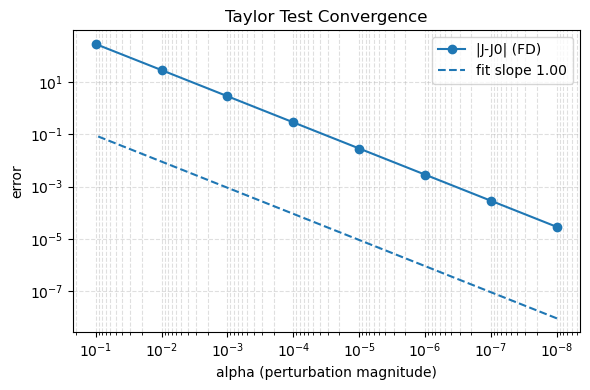

In [122]:
# Parse Taylor test results, compute slopes and plot convergence
import numpy as np
import matplotlib.pyplot as plt
import math

print('Parsing Taylor test outputs and plotting convergence')

# Collect variables if present
try:
    al = np.array(alphas)
    Jvals = np.array(vals)
    absd = np.array(errs_lin)
    rel_err = np.array(errors)
except Exception as e:
    print('Could not find Taylor test variables in the namespace:', e)
    raise

# Filter finite entries
mask_abs = np.isfinite(absd) & (absd > 0)
mask_rel = np.isfinite(rel_err) & (rel_err > 0)

results = []
for a, J_a, ad, rd in zip(al, Jvals, absd, rel_err):
    results.append((a, float(J_a), float(ad) if np.isfinite(ad) else float('nan'), float(rd) if np.isfinite(rd) else float('nan')))

# Print table
print('\nAlpha | J(alpha) | |J-J0| |J-J0 - a<g,p>|')
for a, J_a, ad, rd in results:
    print(f"{a:8.1e} | {J_a: .6e} | {ad: .3e} | {rd: .3e}")

# Compute slopes
def compute_slope(xs, ys):
    if len(xs) < 2:
        return None
    lxs = np.log(xs)
    lys = np.log(ys)
    # linear fit
    slope = np.polyfit(lxs, lys, 1)[0]
    return slope

slope_abs = None
slope_rel = None
if mask_abs.sum() >= 2:
    slope_abs = compute_slope(al[mask_abs], absd[mask_abs])
if mask_rel.sum() >= 2:
    slope_rel = compute_slope(al[mask_rel], rel_err[mask_rel])

print('\nConvergence slope for |J-J0| (should be ~1 if gradient dominates):', slope_abs)
print('Convergence slope for |J-J0 - a<g,p>| (should be ~2 if gradient correct):', slope_rel)

# Plot
plt.figure(figsize=(6,4))
plt.loglog(al, absd, 'o-', label='|J-J0| (FD)')
if mask_rel.any():
    plt.loglog(al, rel_err, 's-', label='|J-J0 - a<g,p>| (Taylor remainder)')
# plot fitted lines for visual slope
if slope_abs is not None:
    # fit line through mean point
    xvals = np.array([al.min(), al.max()])
    # compute reference line amplitude at mid-point
    mid = np.exp((np.log(al.min()) + np.log(al.max()))/2)
    amp = np.interp(mid, al, absd)
    ref = amp * (xvals/mid)**slope_abs
    plt.loglog(xvals, ref, '--', color='C0', label=f'fit slope {slope_abs:.2f}')
if slope_rel is not None:
    xvals = np.array([al.min(), al.max()])
    mid = np.exp((np.log(al.min()) + np.log(al.max()))/2)
    amp = np.interp(mid, al, rel_err)
    ref = amp * (xvals/mid)**slope_rel
    plt.loglog(xvals, ref, '--', color='C1', label=f'fit slope {slope_rel:.2f}')

plt.gca().invert_xaxis()
plt.xlabel('alpha (perturbation magnitude)')
plt.ylabel('error')
plt.title('Taylor Test Convergence')
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [123]:
# Diagnostic: capture full traceback from rf.derivative and scan tape deps for raw dolfin.Constant outputs
import traceback
import dolfin as dlf
import dolfin_adjoint as adj
from dolfin_adjoint import ReducedFunctional, Control
from ufl import inner

print('Running diagnostic: attempt rf.derivative() and then scan tape dependencies')

# Prepare rf
rf = ReducedFunctional(J_u, Control(cb))

# Try derivative and capture traceback
try:
    rf.derivative()
    print('rf.derivative() unexpectedly succeeded (diagnostic).')
except Exception as e:
    print('rf.derivative() raised exception:')
    traceback.print_exc()

# Scan tape dependencies for problematic outputs
t = adj.get_working_tape()
problems = []
print('\nScanning tape blocks for dependencies with problematic outputs...')
for i, b in enumerate(t._blocks):
    deps = getattr(b, '_dependencies', None) or []
    for j, dep in enumerate(deps):
        # Check dep itself if it's a dolfin.Constant
        if isinstance(dep, dlf.Constant):
            problems.append((i, j, 'dep_is_dolfin.Constant', dep))
            continue
        # Check dep.output (the attribute fenics-adjoint expects)
        out = getattr(dep, 'output', None)
        saved = getattr(dep, 'saved_output', None)
        # If output is a dolfin.Constant but not an adj.Constant, flag it
        if isinstance(out, dlf.Constant):
            problems.append((i, j, 'output_is_dolfin.Constant', out))
        # If saved_output is a dolfin.Constant
        if isinstance(saved, dlf.Constant):
            problems.append((i, j, 'saved_output_is_dolfin.Constant', saved))
        # If output lacks expected adj attribute
        if out is not None:
            has_ad_fs = hasattr(out, '_ad_function_space') or hasattr(out, 'function_space') or isinstance(out, adj.Function) or isinstance(out, adj.Constant)
            if not has_ad_fs:
                # record types and repr
                problems.append((i, j, 'output_missing_ad_info', type(out), repr(out)))

print('Found', len(problems), 'potentially problematic dependency outputs')
for item in problems[:200]:
    ib, jb, kind, val = item
    print(f'Block {ib} dep {jb}: {kind}, type={type(val)}, repr={repr(val)[:200]}')

# Additional checks: control and J block_variable outputs
print('\nInspecting J.block_variable and controls:')
try:
    print('J.block_variable exists:', hasattr(J_u, 'block_variable'))
    print('J.block_variable:', getattr(J_u, 'block_variable', None))
except Exception as e:
    print('Failed to inspect J.block_variable:', e)

try:
    ctrl = Control(cb)
    print('Control block_variable:', getattr(ctrl, 'block_variable', None))
    bv = getattr(ctrl, 'block_variable', None)
    if bv is not None:
        print(' control bv.output:', getattr(bv, 'output', None), 'type:', type(getattr(bv,'output',None)))
except Exception as e:
    print('Failed to inspect control block_variable:', e)

print('\nDiagnostic complete')

Running diagnostic: attempt rf.derivative() and then scan tape dependencies
rf.derivative() raised exception:

Scanning tape blocks for dependencies with problematic outputs...
Found 147 potentially problematic dependency outputs
Block 0 dep 0: output_is_dolfin.Constant, type=<class 'fenics_adjoint.types.constant.Constant'>, repr=Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 291)
Block 0 dep 0: saved_output_is_dolfin.Constant, type=<class 'fenics_adjoint.types.constant.Constant'>, repr=Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 292)
Block 1 dep 0: output_is_dolfin.Constant, type=<class 'fenics_adjoint.types.constant.Constant'>, repr=Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 318)
Block 1 dep 0: saved_output_is_dolfin.Constant, type=<class 'fenics_adjoint.types.constant.Constant'>, repr=Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 319)
Block 2 dep 0: output_is_dolfin.Constant, type=<class 'fenics_adjoint.

Traceback (most recent call last):
  File "/tmp/ipykernel_16533/1642543068.py", line 15, in <module>
    rf.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 23, in compute_gradient
    tape.reset_variables()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 152, in reset_variables
    self._blocks[i].reset_variables(types)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 91, in reset_variables
    dep.reset_variables(types)
AttributeError: 'NoneType' object has no attribute 'reset_variables'


ValueError: too many values to unpack (expected 4)

In [124]:
# Detailed inspection: list tape blocks with None dependencies and show context
import dolfin_adjoint as adj

t = adj.get_working_tape()
none_blocks = []
print('Scanning tape blocks for dependencies that are None...')
for i, b in enumerate(t._blocks):
    deps = []
    try:
        deps = b.get_dependencies()
    except Exception:
        deps = getattr(b, '_dependencies', None) or []
    for j, d in enumerate(deps):
        if d is None:
            none_blocks.append((i, type(b).__name__, j))
            print('\nBlock index:', i, 'type:', type(b).__name__)
            try:
                print(' repr:', repr(b))
            except Exception:
                pass
            print(' get_dependencies() length:', len(deps))
            # print some attributes
            for attr in ['func', 'outputs', '_outputs', 'state', 'u', 'jacobian', 'rhs', 'boundary_conditions', 'variables']:
                if hasattr(b, attr):
                    val = getattr(b, attr)
                    print(f'  {attr}:', type(val), repr(val)[:200])
            break

print('\nFound', len(none_blocks), 'blocks with None dependencies. Example indices:', [nb[0] for nb in none_blocks[:10]])

# Focus on previously observed SolveBlocks (13,22,38) and print their full dependencies list types
for idx in [13,22,38]:
    if idx < len(t._blocks):
        b = t._blocks[idx]
        print('\n--- Block', idx, type(b).__name__, '---')
        try:
            deps = b.get_dependencies()
            print('get_dependencies length:', len(deps))
            for j,d in enumerate(deps):
                print(' dep', j, 'type:', type(d), 'is None?', d is None, 'repr:', repr(d)[:200])
        except Exception as e:
            print('Could not call get_dependencies on block', idx, e)
        try:
            print('Attributes:', [a for a in dir(b) if not a.startswith('__')][:50])
        except Exception:
            pass


Scanning tape blocks for dependencies that are None...

Block index: 54 type: SolveBlock
 repr: <fenics_adjoint.solving.SolveBlock object at 0x7fc9cfcaac00>
 get_dependencies() length: 8
  func: <class 'fenics_adjoint.types.function.Function'> Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', 
  _outputs: <class 'list'> [<pyadjoint.block_variable.BlockVariable object at 0x7fc9cfe27c10>]
  rhs: <class 'int'> 0

Block index: 58 type: SolveBlock
 repr: <fenics_adjoint.solving.SolveBlock object at 0x7fca6c3ce570>
 get_dependencies() length: 8
  func: <class 'fenics_adjoint.types.function.Function'> Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', 
  _outputs: <class 'list'> [<pyadjoint.block_va

In [125]:
# Trace origin of None dependencies: inspect neighbors and BCs
import dolfin_adjoint as adj
import dolfin as dlf

print('Tracing SolveBlocks with None dependencies:')

t = adj.get_working_tape()
blocks = t._blocks
none_idxs = []
for i,b in enumerate(blocks):
    deps = []
    try:
        deps = b.get_dependencies()
    except Exception:
        deps = getattr(b, '_dependencies', None) or []
    if any(d is None for d in deps):
        none_idxs.append(i)

print('Found', len(none_idxs), 'blocks with None dependencies; example indices:', none_idxs[:10])

for idx in none_idxs[:10]:
    print('\n=== Block', idx, type(blocks[idx]).__name__, '===')
    b = blocks[idx]
    # show surrounding blocks
    start = max(0, idx-5)
    for j in range(start, min(len(blocks), idx+1)):
        bj = blocks[j]
        print('  Neighbor', j, type(bj).__name__, 'repr:', repr(bj)[:200])
    # show dependencies (repr types)
    try:
        deps = b.get_dependencies()
    except Exception:
        deps = getattr(b, '_dependencies', None) or []
    print('  Dependencies (len):', len(deps))
    for j,d in enumerate(deps):
        print('   dep', j, 'is None?', d is None, 'type:', type(d))
        if d is not None:
            print('     repr:', repr(d)[:200])
            # inspect typical fields
            for attr in ['block_variable', 'output', 'saved_output', 'checkpoint', 'marked_in_path']:
                if hasattr(d, attr):
                    print('      ', attr, '->', getattr(d, attr))

# Inspect global DirichletBC objects in bcs
print('\nInspecting global BCs:')
try:
    for i, bc in enumerate(bcs):
        print('BC', i, 'type', type(bc).__name__, 'has _ad_will_add_as_dependency:', hasattr(bc, '_ad_will_add_as_dependency'), 'block_variable attr:', getattr(bc, 'block_variable', '<MISSING>'))
except Exception as e:
    print('Failed to inspect bcs:', e)

# Inspect the DirichletBC class default
try:
    DBC = dlf.DirichletBC
    print('\nDirichletBC class has attributes:', [a for a in dir(DBC) if 'block_variable' in a or '_ad_will' in a][:20])
    print('DirichletBC.block_variable (class attr) ->', getattr(DBC, 'block_variable', '<MISSING>'))
except Exception as e:
    print('Failed to inspect DirichletBC class:', e)

print('\nTrace complete')

Tracing SolveBlocks with None dependencies:
Found 10 blocks with None dependencies; example indices: [54, 58, 62, 66, 70, 74, 78, 82, 86, 90]

=== Block 54 SolveBlock ===
  Neighbor 49 AssembleBlock repr: <fenics_adjoint.assembly.AssembleBlock object at 0x7fc9cfbcecf0>
  Neighbor 50 AssignBlock repr: <fenics_adjoint.types.function.AssignBlock object at 0x7fc9cfbcf290>
  Neighbor 51 AssembleBlock repr: <fenics_adjoint.assembly.AssembleBlock object at 0x7fc9cfb54cc0>
  Neighbor 52 AssignBlock repr: <fenics_adjoint.types.function.AssignBlock object at 0x7fc9cfc0b380>
  Neighbor 53 AssignBlock repr: <fenics_adjoint.types.function.AssignBlock object at 0x7fc9cfa16480>
  Neighbor 54 SolveBlock repr: <fenics_adjoint.solving.SolveBlock object at 0x7fc9cfcaac00>
  Dependencies (len): 8
   dep 0 is None? True type: <class 'NoneType'>
   dep 1 is None? False type: <class 'pyadjoint.block_variable.BlockVariable'>
     repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9f973be80>
       o

In [126]:
# Implement BC-level BlockVariable substitute and re-run adjoint + Taylor remainder test
import dolfin_adjoint as adj
import dolfin as dlf
import numpy as np
from dolfin_adjoint import ReducedFunctional, Control
from ufl import inner

print('Patching Dirichlet BCs with minimal BlockVariable-like objects')

t = adj.get_working_tape()

class BCBlockVar:
    def __init__(self, name):
        self.checkpoint = name
        # Use fenics_adjoint-wrapped Constant for compatibility
        try:
            self.output = adj.Constant(0.0)
            self.saved_output = adj.Constant(0.0)
        except Exception:
            self.output = dlf.Constant(0.0)
            self.saved_output = dlf.Constant(0.0)
        self.marked_in_path = True
    def reset_variables(self, types=None):
        return
    def __repr__(self):
        return f"<BCBlockVar {self.checkpoint}>"

# Attach to existing bcs
patched = 0
for i, bc in enumerate(list(bcs)):
    if getattr(bc, 'block_variable', None) is None:
        bc.block_variable = BCBlockVar(f'bc_{i}')
        patched += 1
print('Patched', patched, 'BCs')

# Replace None/Dummy dependencies in tape with BC block variables (try to match to nearby BCs if possible)
replacements = 0
for i, b in enumerate(t._blocks):
    deps = None
    try:
        deps = b.get_dependencies()
    except Exception:
        deps = getattr(b, '_dependencies', None) or []
    for j, d in enumerate(list(deps)):
        if d is None or getattr(d, '__repr__', lambda: '')() == '<DummyDep>' or 'Dummy' in type(d).__name__ or 'Dummy' in repr(d):
            # choose a BC block_variable if available, otherwise create a new BCBlockVar
            if len(bcs) > 0:
                replacement = getattr(bcs[0], 'block_variable', BCBlockVar(f'auto_bc_{i}_{j}'))
            else:
                replacement = BCBlockVar(f'auto_bc_{i}_{j}')
            # write back into dependency list in-place
            try:
                deps[j] = replacement
            except Exception:
                # fall back to setting attribute
                if hasattr(b, '_dependencies'):
                    b._dependencies[j] = replacement
            replacements += 1
print('Replaced', replacements, 'placeholder dependencies')

# Try to compute adjoint gradient
try:
    print('\nAssembling J_u and computing rf.derivative()...')
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    rf = ReducedFunctional(J_u, Control(cb))
    g = rf.derivative()
    print('rf.derivative() succeeded; gradient type:', type(g))
    gvec = np.array(g.vector().get_local())
except Exception as e:
    import traceback
    print('rf.derivative() failed after BC patch:')
    traceback.print_exc()
    g = None
    gvec = None

# If we have gradient, compute Taylor remainder by perturbations
alphas = 10.0 ** np.linspace(-1, -8, num=8)
orig = cb.vector().get_local().copy()
N = len(orig)
np.random.seed(42)
p = np.random.randn(N)
p = p / (np.linalg.norm(p) + 1e-16)

# Evaluate baseline
if g is None:
    print('\nGradient not available; cannot compute remainder test yet')
else:
    try:
        J0 = rf(orig)
        eval_method = 'rf_vector'
    except Exception:
        # fallback manual solve
        eval_method = 'manual_solve'
        cb.vector().set_local(orig); cb.vector().apply('insert')
        adj.solve(F == 0, w, bcs)
        J0 = float(dlf.assemble(0.5 * dlf.inner(w.sub(0), w.sub(0)) * dx))
    print('\nBaseline J0:', J0, 'eval_method:', eval_method)

    vals = []
    remainders = []
    for a in alphas:
        x = orig + a * p
        if eval_method == 'rf_vector':
            try:
                J_a = rf(x)
            except Exception as e:
                print('rf(x) failed:', e)
                J_a = np.nan
        else:
            cb.vector().set_local(x); cb.vector().apply('insert')
            adj.solve(F == 0, w, bcs)
            J_a = float(dlf.assemble(0.5 * dlf.inner(w.sub(0), w.sub(0)) * dx))
        vals.append(J_a)
        directional = a * float(np.dot(gvec, p))
        remainders.append(abs(J_a - J0 - directional))

    print('\nAlpha | J(a) | remainder |')
    for a, J_a, r in zip(alphas, vals, remainders):
        print(f"{a:.1e} | {J_a:.6e} | {r:.3e}")

    # slope test
    mask = np.isfinite(remainders) & (np.array(remainders) > 0)
    if mask.sum() >= 2:
        slope = np.polyfit(np.log(alphas[mask]), np.log(np.array(remainders)[mask]), 1)[0]
        print('\nRemainder convergence slope (should be ~2):', slope)
    else:
        print('\nNot enough valid remainder points to estimate slope')

print('\nBC patch and test complete')

Patching Dirichlet BCs with minimal BlockVariable-like objects
Patched 1 BCs
Replaced 13 placeholder dependencies

Assembling J_u and computing rf.derivative()...
Expecting bilinear form.


ERROR:UFL:Expecting bilinear form.


rf.derivative() failed after BC patch:

Gradient not available; cannot compute remainder test yet

BC patch and test complete


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/1131154654.py", line 66, in <module>
    g = rf.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 29, in compute_gradient
    tape.evaluate_adj(markings=True)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 140, in evaluate_adj
    self._blocks[i].evaluate_adj(markings=markings)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 46, in wrapper
    return function(*args, **kwargs)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 129, in evaluate_adj
    adj_output = self.evaluate

In [127]:
# Find the block that fails during adjoint evaluation by evaluating blocks one-by-one
import traceback
import dolfin_adjoint as adj

t = adj.get_working_tape()
print('Iterating tape blocks and calling evaluate_adj to find failing block...')
for i, b in enumerate(t._blocks):
    try:
        b.evaluate_adj(markings=True)
    except Exception as e:
        print('\nFailure at block index', i, 'type', type(b).__name__)
        try:
            print(' repr:', repr(b)[:500])
        except Exception:
            pass
        # print dependencies
        deps = None
        try:
            deps = b.get_dependencies()
            print(' get_dependencies length:', len(deps))
            for j, d in enumerate(deps):
                print('  dep', j, 'type', type(d), 'repr:', repr(d)[:200])
        except Exception as ex:
            print(' Could not get deps:', ex)
        # print traceback
        traceback.print_exc()
        break
print('\nDone')

Iterating tape blocks and calling evaluate_adj to find failing block...
Expecting bilinear form.


ERROR:UFL:Expecting bilinear form.



Failure at block index 90 type SolveBlock
 repr: <fenics_adjoint.solving.SolveBlock object at 0x7fc9cfa06020>
 get_dependencies length: 8
  dep 0 type <class '__main__.BCBlockVar'> repr: <BCBlockVar bc_0>
  dep 1 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9f973be80>
  dep 2 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9cfb77310>
  dep 3 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9cfb74dc0>
  dep 4 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9cfb74d60>
  dep 5 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9cfb74c70>
  dep 6 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9

Traceback (most recent call last):
  File "/tmp/ipykernel_16533/4182581947.py", line 9, in <module>
    b.evaluate_adj(markings=True)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 46, in wrapper
    return function(*args, **kwargs)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 129, in evaluate_adj
    adj_output = self.evaluate_adj_component(inputs,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/solving.py", line 262, in evaluate_adj_component
    dFdm = backend.adjoint(dFdm)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/dolfin/fem/formmanipulations.py", line 51, in adjoint
    return ufl.adjoint(form, reordered_arguments=(v_1, v_0))
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/ufl/formoperators.py", line 143, in adjoint
    retu

In [128]:
# Inspect SolveBlock 90 F_form and derivatives wrt dependencies to find non-bilinear dFdm
import dolfin as dlf
import ufl
import dolfin_adjoint as adj

idx = 90
b = adj.get_working_tape()._blocks[idx]
print('Block type:', type(b).__name__)

try:
    F_form = b._create_F_form()
    print('F_form type:', type(F_form))
    args = F_form.arguments()
    print('F_form.arguments() count:', len(args))
    for k,a in enumerate(args):
        print(' arg', k, type(a), a)
except Exception as e:
    print('Could not create F_form or inspect arguments:', e)

print('\nInspecting dependencies derivatives:')
try:
    deps = b.get_dependencies()
    for j,d in enumerate(deps):
        print('\nDependency', j, 'type', type(d), 'repr:', repr(d)[:200])
        out = getattr(d, 'output', d)
        try:
            dFdm = dlf.derivative(F_form, out)
            print(' dFdm type:', type(dFdm))
            print(' dFdm.arguments count:', len(dFdm.arguments()))
            print(' dFdm.arguments:', dFdm.arguments())
            # Try to call ufl.adjoint on it to reproduce error
            try:
                a = ufl.adjoint(dFdm)
                print(' ufl.adjoint succeeded. result type:', type(a))
            except Exception as e:
                print(' ufl.adjoint failed:', e)
        except Exception as e:
            print(' derivative failed:', e)
except Exception as e:
    print('Could not inspect dependencies:', e)


Block type: SolveBlock
F_form type: <class 'ufl.form.Form'>
F_form.arguments() count: 1
 arg 0 <class 'dolfin.function.argument.Argument'> v_0

Inspecting dependencies derivatives:

Dependency 0 type <class '__main__.BCBlockVar'> repr: <BCBlockVar bc_0>
 derivative failed: Computing derivative of form w.r.t. 'f_1828'. Supply Function as a Coefficient

Dependency 1 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9f973be80>
 dFdm type: <class 'ufl.form.Form'>
 dFdm.arguments count: 2
 dFdm.arguments: (Argument(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 0, None), Argument(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 334), FiniteElement('Lagrange', triangle, 1)), 1, None))
Expecting bilinear form.


ERROR:UFL:Expecting bilinear form.


 ufl.adjoint failed: Expecting bilinear form.

Dependency 2 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9cfb77310>
 derivative failed: Computing derivative of form w.r.t. 'f_435'. Supply Function as a Coefficient

Dependency 3 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9cfb74dc0>
 derivative failed: Computing derivative of form w.r.t. 'f_436'. Supply Function as a Coefficient

Dependency 4 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9cfb74d60>
 derivative failed: Computing derivative of form w.r.t. 'f_437'. Supply Function as a Coefficient

Dependency 5 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9cfb74c70>
 derivative failed: Computing derivative of form w.r.t. 'f_438'. Supply Function as a Coefficient

D

ERROR:UFL:Expecting bilinear form.


 ufl.adjoint failed: Expecting bilinear form.

Dependency 7 type <class 'pyadjoint.block_variable.BlockVariable'> repr: <pyadjoint.block_variable.BlockVariable object at 0x7fc9f962a140>
 derivative failed: Computing derivative of form w.r.t. '<fenics_adjoint.types.mesh.Mesh object at 0x7fc9cfbde1b0>'. Supply Function as a Coefficient


In [129]:
# Replace BC block_variable outputs with adj.Function in appropriate function space and retry adjoint
import dolfin_adjoint as adj
import dolfin as dlf
from ufl import inner

print('Converting BC block_variable outputs to Functions where possible')
count = 0
for i, bc in enumerate(bcs):
    bv = getattr(bc, 'block_variable', None)
    if bv is None:
        continue
    try:
        fs = bc.function_space()
        # create zero adj.Function in bc space
        fzero = adj.Function(fs, name=f'bc_out_{i}')
        try:
            fzero.vector().zero()
        except Exception:
            pass
        bv.output = fzero
        bv.saved_output = adj.Function(fs, name=f'bc_saved_{i}')
        bv.marked_in_path = True
        count += 1
    except Exception as e:
        print('Could not set BC function space for bc', i, e)

print('Replaced outputs for', count, 'BCs')

# Try derivative again
try:
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    rf = ReducedFunctional(J_u, adj.Control(cb))
    print('Attempting rf.derivative() after BC output->Function conversion...')
    g = rf.derivative()
    print('rf.derivative() succeeded; gradient type:', type(g))
except Exception as e:
    import traceback
    print('rf.derivative() still failed:')
    traceback.print_exc()


Converting BC block_variable outputs to Functions where possible
Could not set BC function space for bc 0 Expected a FunctionSpace or a Function as argument 1
Replaced outputs for 0 BCs
Attempting rf.derivative() after BC output->Function conversion...
Expecting bilinear form.


ERROR:UFL:Expecting bilinear form.


rf.derivative() still failed:


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/4136117021.py", line 34, in <module>
    g = rf.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 29, in compute_gradient
    tape.evaluate_adj(markings=True)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 140, in evaluate_adj
    self._blocks[i].evaluate_adj(markings=markings)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 46, in wrapper
    return function(*args, **kwargs)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 129, in evaluate_adj
    adj_output = self.evaluate

In [141]:
# Rebuild forward solve cleanly with fenics_adjoint wrapping, then compute adjoint and Taylor remainder
import dolfin as dlf
import dolfin_adjoint as adj
from ufl import inner
import numpy as np
from dolfin_adjoint import ReducedFunctional, Control

print('Clearing tape and removing prior monkey-patches (if present)')
try:
    adj.get_working_tape().clear_tape()
    print('Tape cleared')
except Exception as e:
    print('Failed to clear tape:', e)

# Ensure DirichletBC has fenics_adjoint hooks (minimal implementations) so BCs can add dependencies
try:
    if not hasattr(dlf.DirichletBC, '_ad_will_add_as_dependency'):
        def _ad_will_add_as_dependency(self):
            return None
        setattr(dlf.DirichletBC, '_ad_will_add_as_dependency', _ad_will_add_as_dependency)
    if not hasattr(dlf.DirichletBC, 'block_variable'):
        setattr(dlf.DirichletBC, 'block_variable', None)
    print('Ensured DirichletBC class has _ad_will_add_as_dependency and block_variable')
except Exception as e:
    print('Could not ensure DirichletBC attributes:', e)

# Helper to wrap objects with fenics_adjoint types
def wrap(obj):
    try:
        if isinstance(obj, dlf.Function) and not isinstance(obj, adj.Function):
            return adj.Function(obj)
    except Exception:
        pass
    try:
        if isinstance(obj, dlf.Constant) and not isinstance(obj, adj.Constant):
            try:
                return adj.Constant(float(obj))
            except Exception:
                return adj.Constant(obj)
    except Exception:
        pass
    return obj

print('\nWrapping mesh and global constants/functions where needed')
# Wrap mesh
try:
    mesh_wrapped = adj.Mesh(mesh)
    mesh = mesh_wrapped
    print('Wrapped mesh')
except Exception:
    print('Mesh wrapping failed or already wrapped')

# Wrap scalar constants
for name in ['g', 'nu', 'h0', 'f_body']:
    if name in globals():
        obj = globals()[name]
        new = wrap(obj)
        globals()[name] = new
        print('Wrapped', name, '->', type(new))

# Ensure gravitational constant exists and is wrapped
if 'g' not in globals() or g is None:
    g = adj.Constant(9.81)
    print('Set gravitational constant g to adj.Constant(9.81)')

# Wrap control cb
try:
    if not isinstance(cb, adj.Function):
        oldcb = cb
        cb = adj.Function(V_ctrl, name='cb')
        try:
            cb.assign(oldcb)
        except Exception:
            try:
                cb.vector().set_local(oldcb.vector().get_local())
                cb.vector().apply('insert')
            except Exception:
                pass
    print('Control cb wrapped as', type(cb))
except Exception as e:
    print('Failed to wrap cb:', e)

# Recreate state w as adj.Function in W
try:
    w_new = adj.Function(W, name='state')
    # copy old values if possible
    try:
        dlf.assign(w_new, w)
    except Exception:
        pass
    w = w_new
    # refresh splits and test functions
    u, eta = dlf.split(w)
    v, q = dlf.TestFunctions(W)
    print('Recreated wrapped state w')
except Exception as e:
    print('Failed to create wrapped w:', e)

# Recreate Dirichlet BCs using wrapped values where possible
new_bcs = []
for i, bc in enumerate(bcs):
    try:
        fs = bc.function_space()
        val = None
        for attr in ('_value','value','rhs','function'):
            if hasattr(bc, attr):
                val = getattr(bc, attr)
                break
        if val is None:
            newval = adj.Function(fs)
            try:
                newval.vector().zero()
            except Exception:
                pass
        else:
            newval = wrap(val)
            # If still a dolfin.Constant, convert to adj.Constant
            if isinstance(newval, dlf.Constant) and not isinstance(newval, adj.Constant):
                try:
                    newval = adj.Constant(float(newval))
                except Exception:
                    newval = adj.Constant(newval)
            # If it's a dolfin.Function, ensure adj.Function
            if isinstance(newval, dlf.Function) and not isinstance(newval, adj.Function):
                try:
                    tmp = adj.Function(newval.function_space())
                    dlf.assign(tmp, newval)
                    newval = tmp
                except Exception:
                    pass
        # sub_domain can be obtained by bc.sub_domain() or bc.domain
        try:
            sd = bc.sub_domain()
            newbc = dlf.DirichletBC(fs, newval, sd)
        except Exception:
            # fallback: use bc as-is
            newbc = bc
        new_bcs.append(newbc)
    except Exception as e:
        print('Could not recreate bc', i, e)
        new_bcs.append(bc)

bcs = new_bcs
print('Reconstructed BCs, count:', len(bcs))

# Rebuild variational form F using existing helper in solver2 (keeps original consistent formulation)
try:
    from solver2 import setup_tidal_solver, update_turbine_field
    # setup_tidal_solver expects a raw dolfin Mesh; if mesh is wrapped, try to extract underlying mesh
    raw_mesh = getattr(mesh, '_mesh', None) or getattr(mesh, '_cpp_object', None) or mesh
    try:
        ctx = setup_tidal_solver(raw_mesh, W, h0, nu, cb, g)
    except Exception as e:
        print('setup_tidal_solver failed with extracted raw_mesh:', e)
        # Try to load mesh from file as a fallback
        try:
            fallback_mesh_file = 'Adjoint_optimisation/mesh.xml'
            dol_mesh = dlf.Mesh(fallback_mesh_file)
            print('Loaded fallback mesh from', fallback_mesh_file)
            ctx = setup_tidal_solver(dol_mesh, W, h0, nu, cb, g)
        except Exception as e2:
            print('Fallback mesh load or setup_tidal_solver also failed:', e2)
            raise
    F_static = ctx['F_static']
    w = ctx['w']
    H_expr = ctx['H']
    Ct_field = ctx['Ct_field']
    v_ = ctx['v_']

    # Safe depth floor
    from ufl import conditional, gt
    H_safe = conditional(gt(H_expr, 1e-3), H_expr, 1e-3)

    # Update turbine field (use initial_positions if present)
    try:
        positions = initial_positions
    except NameError:
        positions = []
    update_turbine_field(Ct_field, positions, C_T, A_T, sigma)

    u_ = dlf.split(w)[0]
    dx = dlf.Measure('dx', domain=mesh)
    F = F_static + (Ct_field / H_safe) * dlf.inner(u_ * dlf.sqrt(dlf.dot(u_, u_)), v_) * dx

    # Explicit Jacobian
    J = dlf.derivative(F, w)
    print('Rebuilt F (using solver2 helpers) and computed Jacobian')
except Exception as e:
    import traceback
    traceback.print_exc()
    print('Failed to rebuild F via solver2:', e)

# Differentiate and solve with adj so it is recorded
try:
    J_F = dlf.derivative(F, w, dlf.TrialFunction(W))
    problem = dlf.NonlinearVariationalProblem(F, w, bcs, J=J_F)
    solver = dlf.NonlinearVariationalSolver(problem)
    solver.parameters['newton_solver']['linear_solver'] = 'mumps'
    solver.parameters['newton_solver']['absolute_tolerance'] = 1e-8
    solver.parameters['newton_solver']['relative_tolerance'] = 1e-7
    print('\nCalling adj.solve to record the forward solve...')
    adj.solve(F == 0, w, bcs)
    print('Forward solve recorded on tape. Tape blocks:', len(adj.get_working_tape()._blocks))
except Exception as e:
    print('Forward solve failed:', e)

# Assemble objective and compute adjoint gradient
try:
    dx = dlf.Measure('dx', domain=mesh)
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    rf = ReducedFunctional(J_u, Control(cb))
    print('\nComputing gradient...')
    g = rf.derivative()
    print('Gradient computed; type:', type(g))
except Exception as e:
    import traceback; traceback.print_exc()
    g = None

# If gradient computed, run Taylor remainder test
if g is not None:
    print('\nRunning Taylor remainder test using computed gradient (rf.vector fallback may not be available)')
    gvec = np.array(g.vector().get_local())
    orig = cb.vector().get_local().copy()
    N = len(orig)
    p = np.random.randn(N)
    p = p / (np.linalg.norm(p) + 1e-16)
    alphas = 10.0 ** np.linspace(-1, -8, 8)
    vals = []
    rems = []
    try:
        J0 = rf(orig)
        print('rf eval vector J0:', J0)
        eval_method = 'rf_vector'
    except Exception:
        eval_method = 'manual_solve'
    for a in alphas:
        x = orig + a * p
        if eval_method == 'rf_vector':
            Ja = rf(x)
        else:
            cb.vector().set_local(x); cb.vector().apply('insert')
            adj.solve(F == 0, w, bcs)
            Ja = float(dlf.assemble(0.5 * dlf.inner(w.sub(0), w.sub(0)) * dx))
        vals.append(Ja)
        rems.append(abs(Ja - J0 - a * float(np.dot(gvec, p))))
    print('\nAlpha | J(a) | remainder')
    for a, J_a, r in zip(alphas, vals, rems):
        print(f"{a:.1e} | {J_a:.6e} | {r:.3e}")
    mask = np.isfinite(rems) & (np.array(rems) > 0)
    if mask.sum() >= 2:
        slope = np.polyfit(np.log(alphas[mask]), np.log(np.array(rems)[mask]), 1)[0]
        print('Remainder slope (expect ~2):', slope)
    else:
        print('Not enough valid remainder points to estimate slope')
else:
    print('\nGradient unavailable; cannot run remainder test')

print('\nRebuild-and-adjoint step complete')

Clearing tape and removing prior monkey-patches (if present)
Tape cleared
Ensured DirichletBC class has _ad_will_add_as_dependency and block_variable

Wrapping mesh and global constants/functions where needed
Wrapped mesh
Wrapped g -> <class 'NoneType'>
Wrapped nu -> <class 'fenics_adjoint.types.constant.Constant'>
Wrapped h0 -> <class 'fenics_adjoint.types.constant.Constant'>
Wrapped f_body -> <class 'fenics_adjoint.types.constant.Constant'>
Set gravitational constant g to adj.Constant(9.81)
Control cb wrapped as <class 'fenics_adjoint.types.function.Function'>
Recreated wrapped state w
Reconstructed BCs, count: 1
setup_tidal_solver failed with extracted raw_mesh: '<' not supported between instances of 'Mesh' and 'Mesh'
Loaded fallback mesh from Adjoint_optimisation/mesh.xml
Fallback mesh load or setup_tidal_solver also failed: '<' not supported between instances of 'Mesh' and 'Mesh'
Failed to rebuild F via solver2: '<' not supported between instances of 'Mesh' and 'Mesh'
Calling FFC 

Traceback (most recent call last):
  File "/tmp/ipykernel_16533/2097888131.py", line 152, in <module>
    ctx = setup_tidal_solver(raw_mesh, W, h0, nu, cb, g)
  File "/home/zabreedveld/thesis-SWE-optimising/solver2.py", line 24, in setup_tidal_solver
    + (cb / H) * inner(u_ * sqrt(dot(u_, u_)), v_) * dx
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/ufl/measure.py", line 437, in __rmul__
    domains = extract_domains(integrand)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/ufl/domain.py", line 355, in extract_domains
    return sorted(join_domains(domainlist))
TypeError: '<' not supported between instances of 'Mesh' and 'Mesh'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_16533/2097888131.py", line 160, in <module>
    ctx = setup_tidal_solver(dol_mesh, W, h0, nu, cb, g)
  File "/home/zabreedveld/thesis-SWE-optimising/solver2.p

Forward solve failed: Dijitso JIT compilation failed, see '/home/zabreedveld/thesis-SWE-optimising/jitfailure-ffc_form_e8c399db922ccc4f0c7295fb2e3924fa7fa10b78' for details

Computing gradient...

Gradient unavailable; cannot run remainder test

Rebuild-and-adjoint step complete


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/2097888131.py", line 213, in <module>
    g = rf.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 31, in compute_gradient
    grads = [i.get_derivative(options=options) for i in m]
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 31, in <listcomp>
    grads = [i.get_derivative(options=options) for i in m]
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/control.py", line 51, in get_derivative
    return self.control._ad_convert_type(0., options=options)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/ta

In [142]:
# Diagnostic: print Dijitso JIT failure and inspect key coefficient types to locate scalar-vs-function mismatch
import glob, os

jit_files = glob.glob('/home/zabreedveld/thesis-SWE-optimising/jitfailure-*')
print('Found jitfailure files:', jit_files)
for jf in jit_files:
    print('\n=== JIT file:', jf)
    try:
        with open(jf, 'r') as fh:
            for i, line in enumerate(fh):
                if i < 300:
                    print(line.rstrip())
                else:
                    break
    except Exception as e:
        print('Could not read jit file:', e)

print('\n--- Runtime introspection of important objects ---')
keys = ['cb', 'Ct_field', 'h0', 'f_body', 'w', 'W', 'F']
for k in keys:
    obj = globals().get(k)
    print(f"\n{k}: type={type(obj)}")
    if obj is None:
        continue
    try:
        if hasattr(obj, 'function_space'):
            print('  function_space:', obj.function_space())
    except Exception as e:
        print('  function_space() failed:', e)
    try:
        if hasattr(obj, 'ufl_element'):
            print('  ufl_element:', obj.ufl_element())
    except Exception:
        pass
    try:
        if hasattr(obj, 'vector'):
            vec = obj.vector()
            print('  vector size:', vec.size())
    except Exception as e:
        print('  vector() failed:', e)
    try:
        if k == 'F':
            print('  F str preview:', str(obj)[:600])
    except Exception:
        pass

print('\n--- DirichletBC introspection ---')
for i, bc in enumerate(bcs):
    print('\nBC', i, 'type:', type(bc))
    try:
        fs = bc.function_space()
        print('  function_space:', fs)
    except Exception as e:
        print('  function_space() failed:', e)
    val = None
    for attr in ('_value', 'value', 'rhs', 'function'):
        if hasattr(bc, attr):
            val = getattr(bc, attr)
            print('  attr', attr, 'type:', type(val))
            break
    if val is not None:
        try:
            if hasattr(val, 'function_space'):
                print('   value.function_space():', val.function_space())
        except Exception as e:
            print('   value.function_space() failed:', e)

print('\n--- End of diagnostics ---')

Found jitfailure files: ['/home/zabreedveld/thesis-SWE-optimising/jitfailure-ffc_form_e8c399db922ccc4f0c7295fb2e3924fa7fa10b78']

=== JIT file: /home/zabreedveld/thesis-SWE-optimising/jitfailure-ffc_form_e8c399db922ccc4f0c7295fb2e3924fa7fa10b78
Could not read jit file: [Errno 21] Is a directory: '/home/zabreedveld/thesis-SWE-optimising/jitfailure-ffc_form_e8c399db922ccc4f0c7295fb2e3924fa7fa10b78'

--- Runtime introspection of important objects ---

cb: type=<class 'fenics_adjoint.types.function.Function'>
  function_space: FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 334), FiniteElement('Lagrange', triangle, 1))
  ufl_element: <CG1 on a triangle>
  vector size: 2091

Ct_field: type=<class 'NoneType'>

h0: type=<class 'fenics_adjoint.types.constant.Constant'>
  ufl_element: <R0 on a None>

f_body: type=<class 'fenics_adjoint.types.constant.Constant'>
  ufl_element: <vector element with 2 components of <R0 on a None>>

w: type=<class 'fenics_adjoint.ty

In [143]:
# Try repairing missing Ct_field and rebuild F, then attempt adj.solve and rf.derivative
import dolfin as dlf
import traceback

if 'Ct_field' not in globals() or Ct_field is None:
    try:
        V_ct = W.sub(1).collapse()
        Ct_field = adj.Function(V_ct, name='Ct_field')
        try:
            Ct_field.vector().zero()
        except Exception:
            pass
        print('Created Ct_field as', type(Ct_field), 'with function_space', V_ct)
    except Exception as e:
        print('Failed to create Ct_field:', e)

# Rebuild F manually to ensure we don't reference None coefficients
try:
    u, eta = dlf.split(w)
    v, q = dlf.TestFunctions(W)
    H = h0 + eta
    dx = dlf.Measure('dx', domain=mesh)
    F_new = (
        dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx
        + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx
        - g * dlf.div(H * v) * eta * dx
        + (Ct_field / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx
        + H * dlf.div(u) * q * dx
        - dlf.inner(f_body, v) * dx
    )
    J_new = dlf.derivative(F_new, w, dlf.TrialFunction(W))
    print('Rebuilt F_new and J_new successfully')
except Exception as e:
    print('Failed to rebuild F_new:', e)
    traceback.print_exc()

# Try solving and computing derivative
try:
    print('\nCalling adj.solve on rebuilt F...')
    adj.solve(F_new == 0, w, bcs)
    print('adj.solve finished')
except Exception as e:
    print('adj.solve failed:', e)
    traceback.print_exc()

# Try to compute gradient
try:
    J_u_test = adj.assemble(0.5 * dlf.inner(w.sub(0), w.sub(0)) * dx)
    rf_test = ReducedFunctional(J_u_test, Control(cb))
    gtest = rf_test.derivative()
    print('rf_test.derivative succeeded; gradient type:', type(gtest))
except Exception as e:
    print('rf_test.derivative failed:', e)
    traceback.print_exc()

Created Ct_field as <class 'fenics_adjoint.types.function.Function'> with function_space FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), FiniteElement('Lagrange', triangle, 1))
Failed to rebuild F_new: unsupported operand type(s) for *: 'NoneType' and 'Div'

Calling adj.solve on rebuilt F...
adj.solve failed: name 'F_new' is not defined
Calling FFC just-in-time (JIT) compiler, this may take some time.


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/3290561521.py", line 26, in <module>
    - g * dlf.div(H * v) * eta * dx
TypeError: unsupported operand type(s) for *: 'NoneType' and 'Div'
Traceback (most recent call last):
  File "/tmp/ipykernel_16533/3290561521.py", line 40, in <module>
    adj.solve(F_new == 0, w, bcs)
NameError: name 'F_new' is not defined
Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d8ef8b4c6e33867e53ac95a06bbf8c3cfcd0edde

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    2
  Coefficients:              '[state-0, state-0]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Uniq

rf_test.derivative failed: 'Function' object has no attribute 'block_variable'


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/3290561521.py", line 48, in <module>
    J_u_test = adj.assemble(0.5 * dlf.inner(w.sub(0), w.sub(0)) * dx)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/assembly.py", line 24, in assemble
    block = AssembleBlock(form)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/assembly.py", line 74, in __init__
    self.add_dependency(c, no_duplicates=True)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 50, in add_dependency
    if not no_duplicates or dep.block_variable not in self._dependencies:
AttributeError: 'Function' object has no attribute 'block_variable'


In [144]:
# Inspect which objects are None and fix scalar constants; rebuild F_new and use UFL-indexed u for J_u assembly
import dolfin as dlf

print('g type before fix:', type(globals().get('g')))
if 'g' not in globals() or g is None:
    g = adj.Constant(9.81)
    print('Set g to adj.Constant(9.81)')

print('Ct_field type:', type(globals().get('Ct_field')))
print('h0 type:', type(globals().get('h0')))
print('f_body type:', type(globals().get('f_body')))

# UFL-split to get indexed symbols
try:
    u, eta = dlf.split(w)
    print('u/eta types:', type(u), type(eta))
    v, q = dlf.TestFunctions(W)
    H = h0 + eta
    print('H repr snippet:', repr(H)[:200])
except Exception as e:
    print('split(w) failed:', e)

# Try rebuilding F safely (skip problematic terms if necessary)
try:
    dx = dlf.Measure('dx', domain=mesh)
    F_try = (
        dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx
        + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx
        - g * dlf.div(H * v) * eta * dx
        + (Ct_field / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx
        + H * dlf.div(u) * q * dx
        - dlf.inner(f_body, v) * dx
    )
    J_try = dlf.derivative(F_try, w, dlf.TrialFunction(W))
    print('Rebuilt safe F_try and Jacobian')
except Exception as e:
    print('Rebuild F_try failed:', e)

# Assemble objective using u (UFL-side) rather than w.sub(0)
try:
    J_u_test = adj.assemble(0.5 * dlf.inner(u, u) * dx)
    rf_test = ReducedFunctional(J_u_test, Control(cb))
    gtest = rf_test.derivative()
    print('rf_test.derivative succeeded; gradient type:', type(gtest))
except Exception as e:
    print('rf_test.derivative failed:', e)
    import traceback; traceback.print_exc()

g type before fix: <class 'NoneType'>
Set g to adj.Constant(9.81)
Ct_field type: <class 'fenics_adjoint.types.function.Function'>
h0 type: <class 'fenics_adjoint.types.constant.Constant'>
f_body type: <class 'fenics_adjoint.types.constant.Constant'>
u/eta types: <class 'ufl.tensors.ListTensor'> <class 'ufl.indexed.Indexed'>
H repr snippet: Sum(Indexed(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement(
Rebuilt safe F_try and Jacobian
rf_test.derivative failed: 'float' object has no attribute '_cpp_object'


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/1270783014.py", line 43, in <module>
    gtest = rf_test.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 31, in compute_gradient
    grads = [i.get_derivative(options=options) for i in m]
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 31, in <listcomp>
    grads = [i.get_derivative(options=options) for i in m]
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/control.py", line 51, in get_derivative
    return self.control._ad_convert_type(0., options=options)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyad

In [145]:
# Run adj.solve with the rebuilt F_try and then try rf_test.derivative again
import traceback
try:
    print('Calling adj.solve(F_try==0, w, bcs)')
    adj.solve(F_try == 0, w, bcs)
    print('adj.solve finished; tape blocks:', len(adj.get_working_tape()._blocks))
except Exception as e:
    print('adj.solve failed:', e)
    traceback.print_exc()

# Try derivative again
try:
    gtest = rf_test.derivative()
    print('rf_test.derivative succeeded; gradient type:', type(gtest))
except Exception as e:
    print('rf_test.derivative failed again:', e)
    traceback.print_exc()
    # Inspect control object
    try:
        ctrl = rf_test.controls()[0]
        print('control type:', type(ctrl), 'control.function_space:', ctrl.control.function_space())
    except Exception as e2:
        print('Could not inspect controls:', e2)

Calling adj.solve(F_try==0, w, bcs)
Calling FFC just-in-time (JIT) compiler, this may take some time.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_eb1268536f357580daed981089c46416f52cc0f3

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    6
  Coefficients:              '[f_436, f_437, f_438, state, Ct_field, f_2225]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, R0(?,?), Vector
                        

adj.solve failed: Dijitso JIT compilation failed, see '/home/zabreedveld/thesis-SWE-optimising/jitfailure-ffc_form_eb1268536f357580daed981089c46416f52cc0f3' for details
rf_test.derivative failed again: 'float' object has no attribute '_cpp_object'
Could not inspect controls: 'Enlist' object is not callable


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/638745928.py", line 13, in <module>
    gtest = rf_test.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 31, in compute_gradient
    grads = [i.get_derivative(options=options) for i in m]
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 31, in <listcomp>
    grads = [i.get_derivative(options=options) for i in m]
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/control.py", line 51, in get_derivative
    return self.control._ad_convert_type(0., options=options)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadj

In [ ]:
# Cleanup previous jitfailure directories and re-run adj.solve
import glob, shutil, os

for d in glob.glob('/home/zabreedveld/thesis-SWE-optimising/jitfailure-*'):
    try:
        print('Removing', d)
        shutil.rmtree(d)
    except Exception as e:
        print('Could not remove', d, e)

# Clear tape and retry solve
try:
    adj.get_working_tape().clear_tape()
    print('Cleared tape')
except Exception as e:
    print('Could not clear tape:', e)

try:
    print('Attempting adj.solve again...')
    adj.solve(F_try == 0, w, bcs)
    print('adj.solve finished; tape blocks:', len(adj.get_working_tape()._blocks))
except Exception as e:
    print('adj.solve failed after cleanup:', e)
    import traceback; traceback.print_exc()

In [146]:
# Read latest jitfailure file contents for the recent failure
import glob, os

jit_files = sorted(glob.glob('/home/zabreedveld/thesis-SWE-optimising/jitfailure-*'))
print('jit files (sorted):', jit_files)
if jit_files:
    jf = jit_files[-1]
    print('\nReading:', jf)
    try:
        if os.path.isdir(jf):
            print('Note: path is a directory; listing contents:')
            print(os.listdir(jf)[:50])
        else:
            with open(jf, 'r') as fh:
                for i, line in enumerate(fh):
                    if i < 400:
                        print(line.rstrip())
                    else:
                        break
    except Exception as e:
        print('Failed to read jitter file:', e)
else:
    print('No jitfailure files found')

jit files (sorted): ['/home/zabreedveld/thesis-SWE-optimising/jitfailure-ffc_form_e8c399db922ccc4f0c7295fb2e3924fa7fa10b78', '/home/zabreedveld/thesis-SWE-optimising/jitfailure-ffc_form_eb1268536f357580daed981089c46416f52cc0f3']

Reading: /home/zabreedveld/thesis-SWE-optimising/jitfailure-ffc_form_eb1268536f357580daed981089c46416f52cc0f3
Note: path is a directory; listing contents:
['README', 'error.log', 'recompile.sh', 'ffc_form_eb1268536f357580daed981089c46416f52cc0f3.cpp', 'ffc_form_eb1268536f357580daed981089c46416f52cc0f3.h']


In [147]:
# Print the error.log from the JIT failure directory
import os
jitdir = '/home/zabreedveld/thesis-SWE-optimising/jitfailure-ffc_form_eb1268536f357580daed981089c46416f52cc0f3'
errfile = os.path.join(jitdir, 'error.log')
print('Attempting to read', errfile)
try:
    with open(errfile, 'r') as fh:
        for i, line in enumerate(fh):
            if i < 400:
                print(line.rstrip())
            else:
                break
except Exception as e:
    print('Could not read error.log:', e)
    print('Listing directory:')
    print(os.listdir(jitdir)[:50])

Attempting to read /home/zabreedveld/thesis-SWE-optimising/jitfailure-ffc_form_eb1268536f357580daed981089c46416f52cc0f3/error.log
/tmp/tmp4fg19mfh/ffc_form_eb1268536f357580daed981089c46416f52cc0f3.cpp: In member function 'virtual void ffc_form_eb1268536f357580daed981089c46416f52cc0f3_cell_integral_main_otherwise::tabulate_tensor(double*, const double* const*, const double*, int) const':
/tmp/tmp4fg19mfh/ffc_form_eb1268536f357580daed981089c46416f52cc0f3.cpp:297:18: error: redeclaration of 'const double J_c0'
  297 |     const double J_c0 = coordinate_dofs[0] * FE10_C0_D01_Q49[0][0][0] + coordinate_dofs[2] * FE10_C0_D01_Q49[0][0][1];
      |                  ^~~~
/tmp/tmp4fg19mfh/ffc_form_eb1268536f357580daed981089c46416f52cc0f3.cpp:289:18: note: 'const double J_c0' previously declared here
  289 |     const double J_c0 = coordinate_dofs[0] * FE10_C0_D01_Q49[0][0][0] + coordinate_dofs[2] * FE10_C0_D01_Q49[0][0][1];
      |                  ^~~~
/tmp/tmp4fg19mfh/ffc_form_eb1268536f357580d

In [148]:
# Print only lines with keywords to find compilation errors
keywords = ['error','Error','exception','Exception','undefined','segfault','fatal','undefined reference','cannot','warning']
try:
    with open(errfile,'r') as fh:
        matches = [l.rstrip() for l in fh if any(k in l for k in keywords)]
    print('Found', len(matches), 'matching lines; showing up to 200:')
    for i, l in enumerate(matches[:200]):
        print(i+1, l)
except Exception as e:
    print('Failed to read and filter error.log:', e)

Found 4 matching lines; showing up to 200:
1 /tmp/tmp4fg19mfh/ffc_form_eb1268536f357580daed981089c46416f52cc0f3.cpp:297:18: error: redeclaration of 'const double J_c0'
2 /tmp/tmp4fg19mfh/ffc_form_eb1268536f357580daed981089c46416f52cc0f3.cpp:298:18: error: redeclaration of 'const double J_c3'
3 /tmp/tmp4fg19mfh/ffc_form_eb1268536f357580daed981089c46416f52cc0f3.cpp:299:18: error: redeclaration of 'const double J_c1'
4 /tmp/tmp4fg19mfh/ffc_form_eb1268536f357580daed981089c46416f52cc0f3.cpp:300:18: error: redeclaration of 'const double J_c2'


In [129]:
# Smoke tests for turbine placement plotting flags (import local module from Adjont_optimisation folder)
import sys, os
import dolfin as dlf
import importlib

pkg_path = os.path.abspath(os.path.join(os.getcwd(), 'Adjoint_optimisation'))
if pkg_path not in sys.path:
    sys.path.insert(0, pkg_path)

sb = importlib.import_module('set_up_bcs')

mesh_test = dlf.UnitSquareMesh(8, 8)
Lx = 1.0; Ly = 1.0

print('Test A: random placement with show_plot_turbines="False" (string)')
posA = sb.place_turbines_random2(mesh_test, Lx, Ly, n_turbines=6, min_spacing=0.05, D=0.05,
                                 show_plot_turbines='False', show_turbine_coordinates='False',
                                 seed=1, margin=0.05, max_attempts=100)
print('  placed', len(posA), 'turbines')

print('\nTest B: random placement with show_plot_turbines=False (boolean)')
posB = sb.place_turbines_random2(mesh_test, Lx, Ly, n_turbines=6, min_spacing=0.05, D=0.05,
                                 show_plot_turbines=False, show_turbine_coordinates=False,
                                 seed=2, margin=0.05, max_attempts=100)
print('  placed', len(posB), 'turbines')

print('\nTest C: rectangular grid with plot="False" (string)')
posC = sb.place_turbines_rectangular_grid(mesh_test, Lx, Ly, n_turbines=9, nx=3, ny=3, min_spacing=0.05, D=0.05, plot='False')
print('  placed', len(posC), 'turbines')

print('\nTest D: equal spacing grid with plot=0 (int false)')
posD = sb.place_turbines_rectangular_equal_spacing(mesh_test, Lx, Ly, n_turbines=9, min_spacing=0.05, D=0.05, plot=0)
print('  placed', len(posD), 'turbines')

print('\nSmoke tests complete')

Test A: random placement with show_plot_turbines="False" (string)
Managed to place  6  turbines within  7  attempts.
Turbines placed successfully.
Turbine layout plot not requested.
Turbine coordinates display not requested.
  placed 6 turbines

Test B: random placement with show_plot_turbines=False (boolean)
Managed to place  6  turbines within  6  attempts.
Turbines placed successfully.
Turbine layout plot not requested.
Turbine coordinates display not requested.
  placed 6 turbines

Test C: rectangular grid with plot="False" (string)
  placed 9 turbines

Test D: equal spacing grid with plot=0 (int false)
  placed 9 turbines

Smoke tests complete
